# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[100]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[150]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[490]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
Although this seems like a great product it is definitely not minced.  The cans say it is minced but it isn't, it is ground beef.  My cat ONLY likes minced.  Not chunks, not ground.  Although she will eat ground cat food sometimes, it has to be inviting and delicious, yet she just walks away from this.<br /><br />I hate it when the packaging lies about the contents of a product.  The shipping was speedy and the value is great (as long as they deliver what the promise) now I am stuck with food my cat wont eat at all.
"These are delicious! The chocolate is excellent and the espresso bean was the perfect roast for this purpose. Crunchy and not bitter."<a href="http://www.amazon.com/gp/product/B00067AD4U">Chocolate Covered Espr

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
Although this seems like a great product it is definitely not minced.  The cans say it is minced but it isn't, it is ground beef.  My cat ONLY likes minced.  Not chunks, not ground.  Although she will eat ground cat food sometimes, it has to be inviting and delicious, yet she just walks away from this.I hate it when the packaging lies about the contents of a product.  The shipping was speedy and the value is great (as long as they deliver what the promise) now I am stuck with food my cat wont eat at all.
"These are delicious! The chocolate is excellent and the espresso bean was the perfect roast for this purpose. Crunchy and not bitter."Chocolate Covered Espresso Beans 5 Pounds
THESE CRACKERS ARE A GREAT SNACK! NO CHOLESTORAL, AND THEY USE SEA SALT. VERY CRUNCHY, SO ITS LIKE EATING POTATO CHIPS, BUT BE

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

"These are delicious! The chocolate is excellent and the espresso bean was the perfect roast for this purpose. Crunchy and not bitter."<a href="http://www.amazon.com/gp/product/B00067AD4U">Chocolate Covered Espresso Beans 5 Pounds</a>


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

 These are delicious The chocolate is excellent and the espresso bean was the perfect roast for this purpose Crunchy and not bitter a href http www amazon com gp product B00067AD4U Chocolate Covered Espresso Beans 5 Pounds a 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:02<00:00, 1760.45it/s]


In [25]:
# Combining all the above stundents 
from tqdm import tqdm
summary_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    summary_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 2557.72it/s]


In [26]:
preprocessed_reviews[150]

'delicious chocolate excellent espresso bean perfect roast purpose crunchy not bitter'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [72]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['abby', 'abdominal', 'able', 'absence', 'absolute', 'absolutely', 'absorbs', 'abt', 'acai', 'accept']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (499, 3836)
the number of unique words  3836


## [4.2] Bi-Grams and n-Grams.

In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [31]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

In [28]:
# Please write all the code with proper documentation
length_of_summary=[]
for i in range(len(summary_reviews)):
    length_of_summary.append(len(summary_reviews[i]))

In [29]:
print(length_of_summary[:5])

[12, 12, 18, 13, 10]


In [30]:
final['length_of_Summary']=length_of_summary

In [31]:
for i in range(len(preprocessed_reviews)):
    preprocessed_reviews[i]=preprocessed_reviews[i]+' '+summary_reviews[i]

In [32]:
%%time
#Reference: https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
#Refernce:https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
lemmatizer = WordNetLemmatizer()

def lem_Sentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    lem_sentence=[]
    for word in token_words:
        lem_sentence.append(lemmatizer.lemmatize(word))
        lem_sentence.append(" ")
    return "".join(lem_sentence)
for i in range(len(preprocessed_reviews)):
     preprocessed_reviews[i]=lem_Sentence(preprocessed_reviews[i])
     print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697


In [33]:
final['clean_text']=preprocessed_reviews

In [34]:
final=final.sort_values('Time',ascending=True)

In [35]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final['clean_text'], final['Score'],random_state = 0, test_size = 0.2,shuffle = False)
x_tr, x_cv, y_tr, y_cv = train_test_split(x_train, y_train, random_state = 0, test_size = 0.25, shuffle = False)
# here we split the train data into train and cross validate

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [35]:
%%time
# Please write all the code with proper documentation

#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(final['clean_text'])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_x_train = count_vect.transform(final['clean_text'])     #  y_tr



some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaagh', 'aaaaaawwwwwwwwww', 'aaaaah']
Wall time: 5.99 s


In [36]:
import scipy
from scipy.sparse import coo_matrix,hstack

In [37]:
length_of_summary=np.array(length_of_summary)

In [38]:
np.hstack((final_counts_x_train,length_of_summary[:50000]))

array([<46071x36850 sparse matrix of type '<class 'numpy.int64'>'
	with 1548231 stored elements in Compressed Sparse Row format>,
       10, 17, ..., 17, 18, 27], dtype=object)

In [39]:
from sklearn.preprocessing import normalize
final_counts_x_train=normalize(final_counts_x_train)


In [40]:
%%time
from sklearn.cluster import KMeans


k_inertia=[]

k=[2,4,6,8]
for i in k:

        k_m= KMeans(n_clusters=i,init='k-means++', random_state=0)
        k_m.fit(final_counts_x_train)
        k_inertia.append(k_m.inertia_)
        print("cluster",i,"done")
    

cluster 2 done
cluster 4 done
cluster 6 done
cluster 8 done
Wall time: 31min 11s


In [41]:
print(k_inertia)

[42183.81334681314, 40975.79231358875, 40230.55779657214, 39682.21920281708]


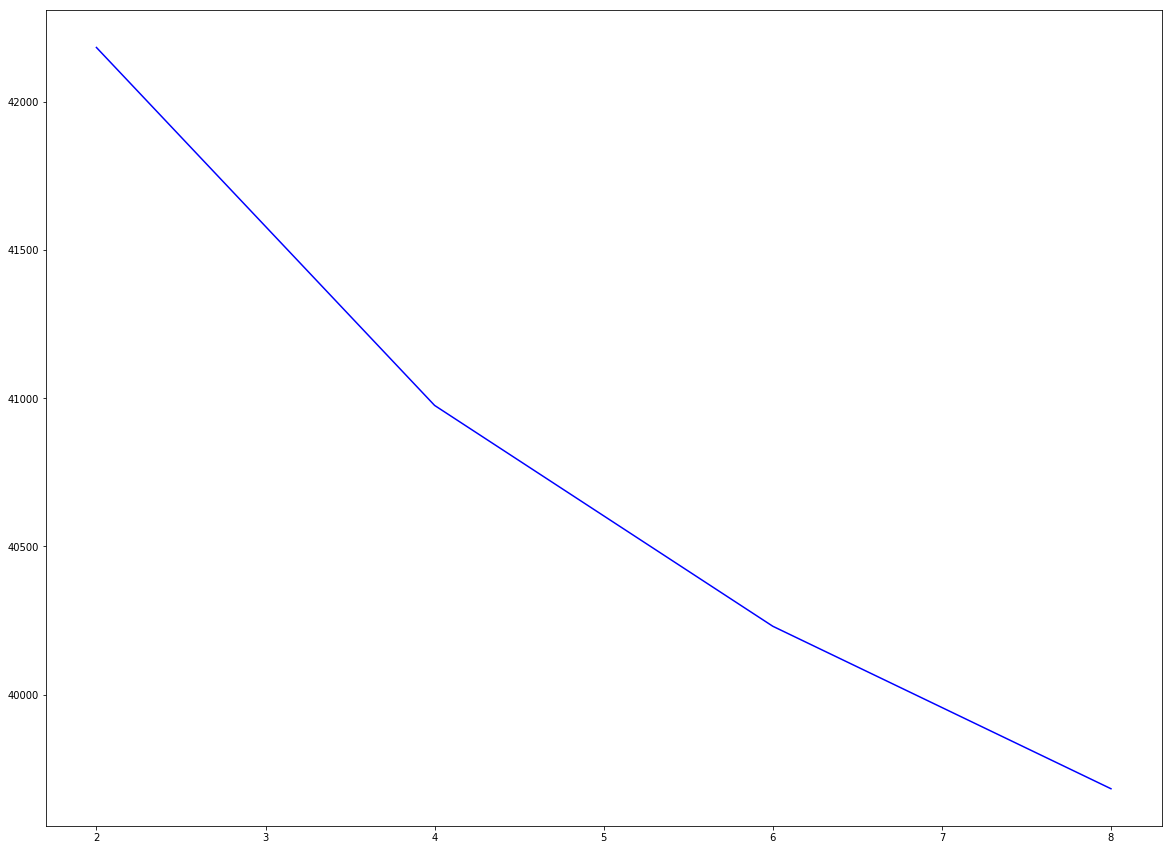

In [42]:
plt.figure(figsize = (20,15))
plt.plot(k,k_inertia,color='blue')

In [43]:
best_k=8

In [44]:
label=KMeans(n_clusters=best_k,init='k-means++', random_state=0).fit(final_counts_x_train).labels_

In [45]:
print(np.unique(label))

[0 1 2 3 4 5 6 7]


In [46]:
print(len(label))

46071


now we will label each review

In [47]:
final['cluster_no']=label

In [48]:
print(k)

[2, 4, 6, 8]


In [49]:
groups=[]
for i in (np.unique(label)):
    print("cluster  is",i)
    print("****************")
    length_per_cluster=len(final[final['cluster_no']==i])
    print(length_per_cluster)
    rand_ind=np.random.randint(low=0,high=length_per_cluster,size=1)
    for n in rand_ind:
        line=final[final['cluster_no']==i]['clean_text'].iloc[n]
        print(line)
     #print(length_per_cluster)
    groups.append(line)

cluster  is 0
****************
3074
repeat purchase used c e chew year dog previously purchasing veterinarian found order amazon com better price purchasing chew amazon use large dog weigh pound perfect size satisfy chewing need help keep teeth gum good condition good product 
cluster  is 1
****************
1715
chocolate moose mickey moose nice owner bought great food u love much gained lb eat mickey food not looking skin fur much better good food 
cluster  is 2
****************
6129
really like product beat brushing dog teeth using year kekep teeth great condition first gave week sensitive stomach tolerates daily great teeth 
cluster  is 3
****************
2877
fan flowery tea definitely wonderful addition tea assortment great value delicious tea 
cluster  is 4
****************
9368
found mix ft myer commissary looked product last time visited commissary could not find online looking found could eat day tried several different snack mix many pretzel nice balance flavor texture not lo

In [50]:
print(groups)

['repeat purchase used c e chew year dog previously purchasing veterinarian found order amazon com better price purchasing chew amazon use large dog weigh pound perfect size satisfy chewing need help keep teeth gum good condition good product ', 'chocolate moose mickey moose nice owner bought great food u love much gained lb eat mickey food not looking skin fur much better good food ', 'really like product beat brushing dog teeth using year kekep teeth great condition first gave week sensitive stomach tolerates daily great teeth ', 'fan flowery tea definitely wonderful addition tea assortment great value delicious tea ', 'found mix ft myer commissary looked product last time visited commissary could not find online looking found could eat day tried several different snack mix many pretzel nice balance flavor texture not lot pretzel stocking pub mix addicting ', 'like quality la tourangelle buy alot sesame oil decided try avacado oil like experiment different ingredient not eat meat ava

In [51]:
len(final[final['cluster_no']==2])

6129

In [52]:
print(groups)

['repeat purchase used c e chew year dog previously purchasing veterinarian found order amazon com better price purchasing chew amazon use large dog weigh pound perfect size satisfy chewing need help keep teeth gum good condition good product ', 'chocolate moose mickey moose nice owner bought great food u love much gained lb eat mickey food not looking skin fur much better good food ', 'really like product beat brushing dog teeth using year kekep teeth great condition first gave week sensitive stomach tolerates daily great teeth ', 'fan flowery tea definitely wonderful addition tea assortment great value delicious tea ', 'found mix ft myer commissary looked product last time visited commissary could not find online looking found could eat day tried several different snack mix many pretzel nice balance flavor texture not lot pretzel stocking pub mix addicting ', 'like quality la tourangelle buy alot sesame oil decided try avacado oil like experiment different ingredient not eat meat ava

In [53]:
print(len(groups))

8



### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [50]:
from wordcloud import WordCloud

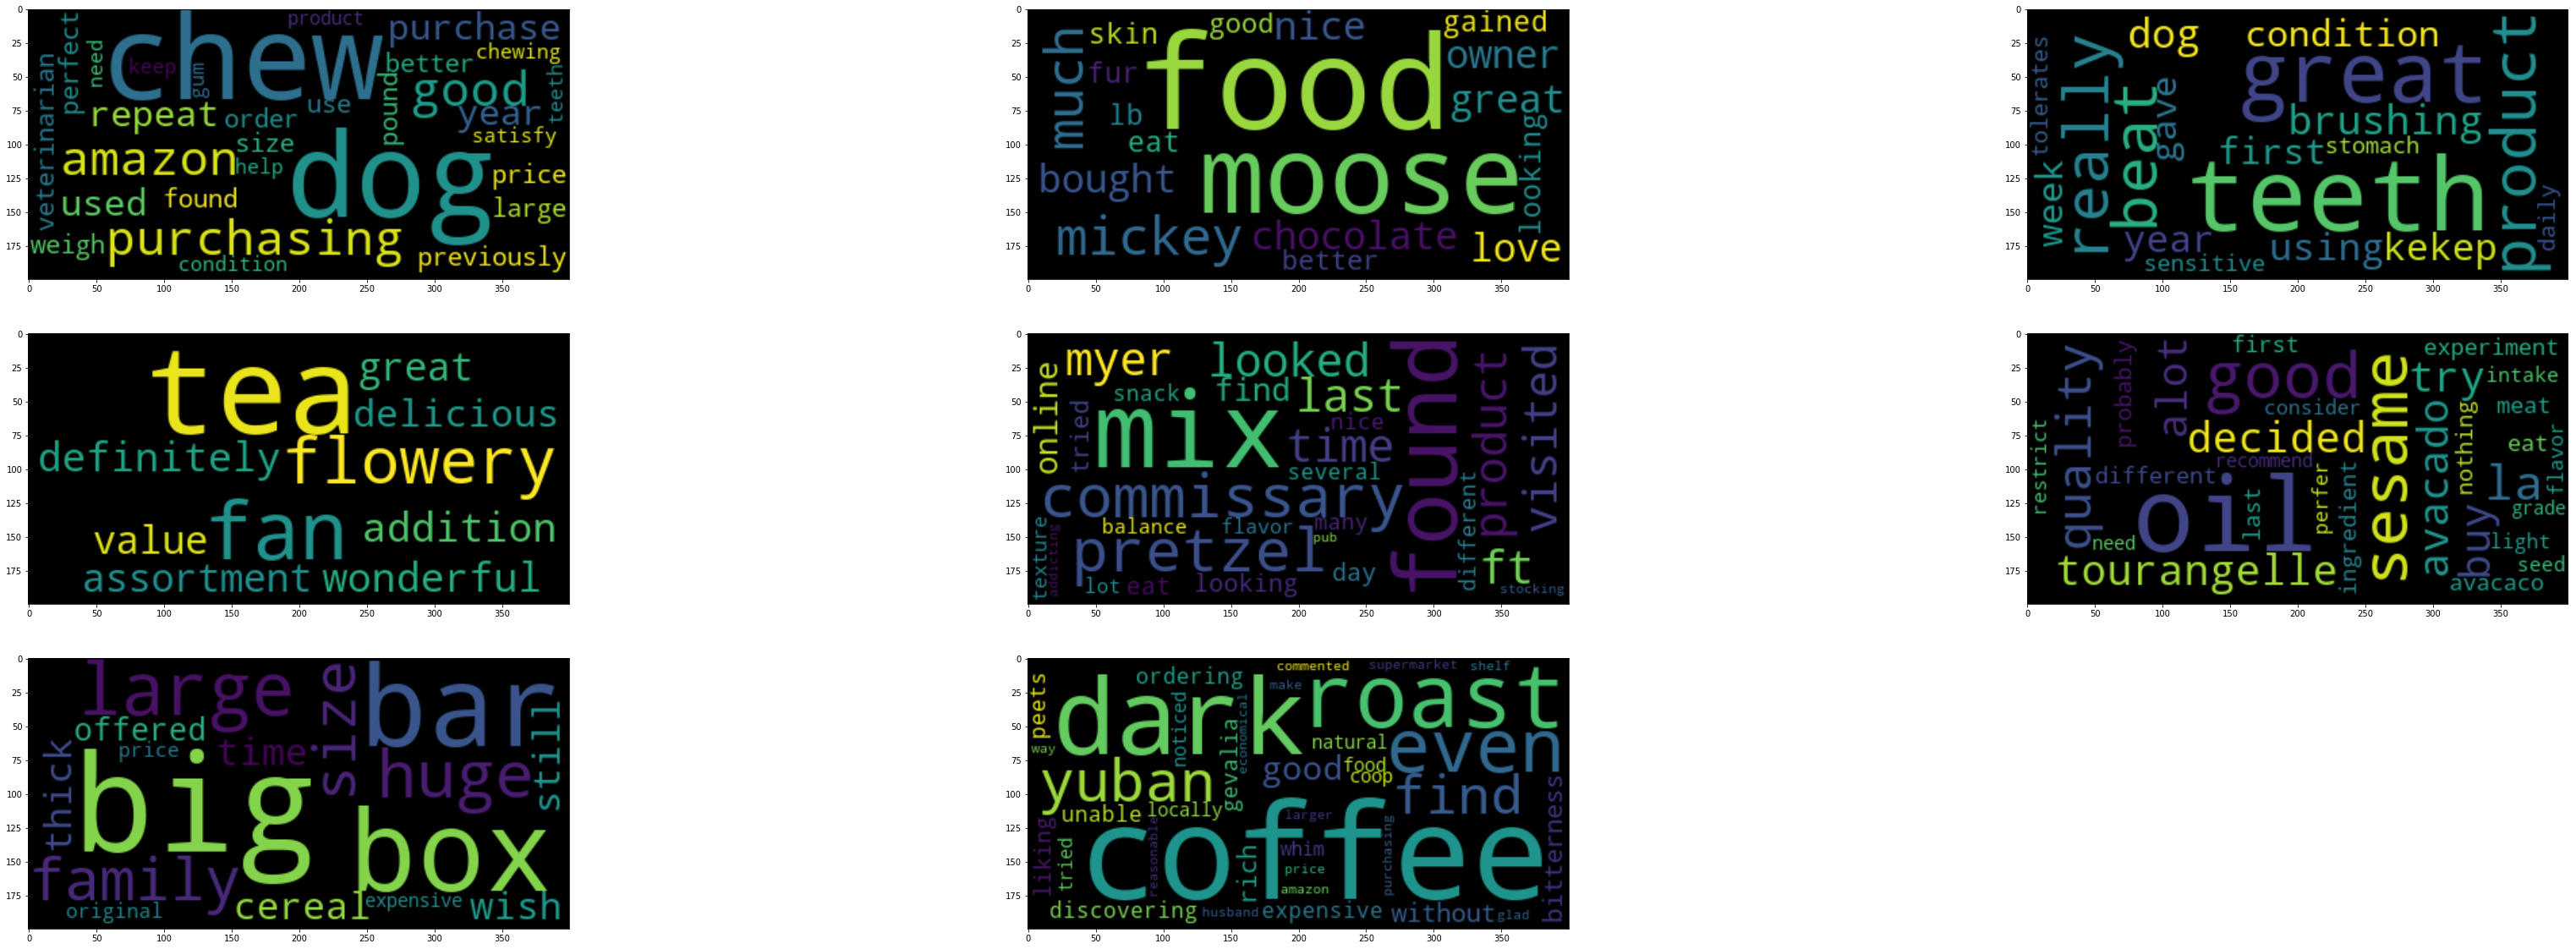

In [55]:
    plt.figure(figsize=(60,20))
    plt.subplot(3, 3, 1)
   
    wordcloud = WordCloud().generate(groups[0])


    plt.imshow(wordcloud, interpolation='bilinear')
    
    
    plt.subplot(3, 3, 2)
    
    wordcloud = WordCloud().generate(groups[1])


    plt.imshow(wordcloud, interpolation='bilinear')
    plt.subplot(3, 3, 3)
    
    wordcloud = WordCloud().generate(groups[2])


    plt.imshow(wordcloud, interpolation='bilinear')
    plt.subplot(3, 3, 4)
    
    
    wordcloud = WordCloud().generate(groups[3])


    plt.imshow(wordcloud, interpolation='bilinear')
    plt.subplot(3, 3, 5)
    
     
    wordcloud = WordCloud().generate(groups[4])


    plt.imshow(wordcloud, interpolation='bilinear')
    plt.subplot(3, 3, 6)
    
     
    wordcloud = WordCloud().generate(groups[5])


    plt.imshow(wordcloud, interpolation='bilinear')
    plt.subplot(3, 3,7)
    
    
    wordcloud = WordCloud().generate(groups[6])


    plt.imshow(wordcloud, interpolation='bilinear')
    plt.subplot(3, 3,8)
    
    
    wordcloud = WordCloud().generate(groups[7])


    plt.imshow(wordcloud, interpolation='bilinear')
   

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [56]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_vect.fit(final['clean_text'])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


final_tf_idf_tr = tf_idf_vect.transform(final['clean_text'])
print("the type of count vectorizer ",type(final_tf_idf_tr))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_tr.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_tr.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aa dark', 'aa kona', 'aa quality', 'aa really', 'aa sumatra', 'aa talk', 'aa year', 'aaa', 'aaa marketing']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 830610)
the number of unique words including both unigrams and bigrams  830610


In [58]:
np.hstack((final_tf_idf_tr,length_of_summary[:50000]))

array([<46071x830610 sparse matrix of type '<class 'numpy.float64'>'
	with 3375551 stored elements in Compressed Sparse Row format>,
       10, 17, ..., 13, 42, 9], dtype=object)

In [59]:
from sklearn.preprocessing import normalize
final_tf_idf_tr=normalize(final_tf_idf_tr)

In [60]:
%%time
from sklearn.cluster import KMeans


k_inertia=[]

k=[1,3,5,7,9]
for i in k:

        k_m= KMeans(n_clusters=i,init='k-means++', random_state=0)
        k_m.fit(final_tf_idf_tr)
        k_inertia.append(k_m.inertia_)
        print("clustered the data with",i)
    

clustered the data with 1
clustered the data with 3
clustered the data with 5
clustered the data with 7
clustered the data with 9
Wall time: 1h 25min 5s


In [61]:
print(k_inertia)

[45752.197062881416, 45536.999476503515, 45390.733786415294, 45296.310980124115, 45224.09259934832]


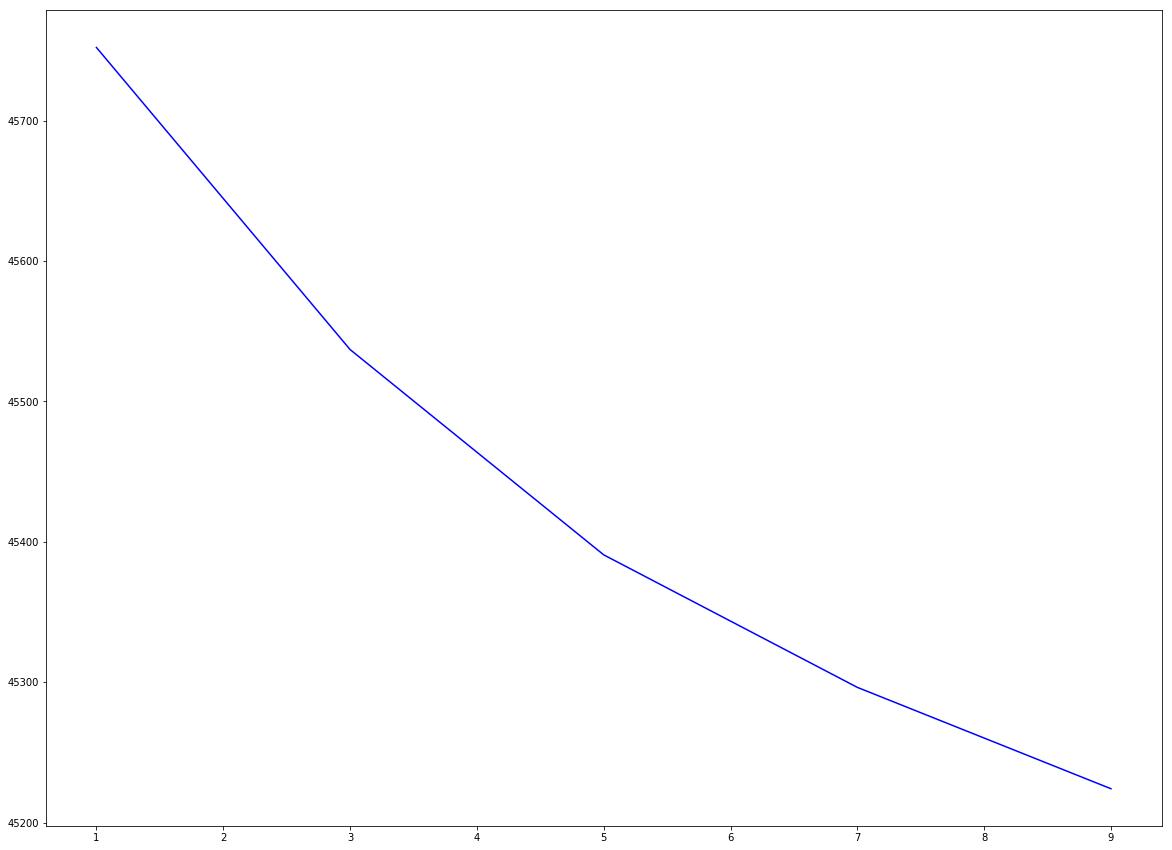

In [62]:
plt.figure(figsize = (20,15))
plt.plot(k,k_inertia,color='blue')

In [63]:
best_k=9

In [ ]:
label=KMeans(n_clusters=best_k,init='k-means++', random_state=0).fit(final_tf_idf_tr).labels_

In [65]:
label=k_m.labels_

In [66]:
final['cluster_no']=label

In [67]:
groups=[]
for i in (np.unique(label)):
    print("cluster  is",i)
    print("****************")
    length_per_cluster=len(final[final['cluster_no']==i])
    print(length_per_cluster)
    rand_ind=np.random.randint(low=0,high=length_per_cluster,size=1)
    for n in rand_ind:
        line=final[final['cluster_no']==i]['clean_text'].iloc[n]
        print(line)
     #print(length_per_cluster)
    groups.append(line)

cluster  is 0
****************
1552
milk chocolate made best ingredient ingredient use vanilla cocoa butter whole milk powder hershey us vanillin wood extract bag given snack letting melt tongue taste almost orgasmic caramel flavor stay like ten minute eating ever chocolate eat let melt tongue first instead chomping one eat le two appreciate three taste flavor better chocolate 
cluster  is 1
****************
3590
huge coffee drinker caribou become favorite coffee bold not bitter purchase product every month caribou coffee 
cluster  is 2
****************
8987
popcorn not taste great pop well unpopped kernel believe normal brand reading review noted not pop well went phase found problem popper fixed popcorn popped storm many friend visited home theater commented good flavor great northern popcorn great price highly recommended great tasting popcorn 
cluster  is 3
****************
22172
refunded due damaged can amazon customer service friendly apologetic good price delivery prompt elderly

In [68]:
print(groups)

['milk chocolate made best ingredient ingredient use vanilla cocoa butter whole milk powder hershey us vanillin wood extract bag given snack letting melt tongue taste almost orgasmic caramel flavor stay like ten minute eating ever chocolate eat let melt tongue first instead chomping one eat le two appreciate three taste flavor better chocolate ', 'huge coffee drinker caribou become favorite coffee bold not bitter purchase product every month caribou coffee ', 'popcorn not taste great pop well unpopped kernel believe normal brand reading review noted not pop well went phase found problem popper fixed popcorn popped storm many friend visited home theater commented good flavor great northern popcorn great price highly recommended great tasting popcorn ', 'refunded due damaged can amazon customer service friendly apologetic good price delivery prompt elderly dog can not risk chance bacteria broken seal canned food packaging poor need better protect product star review strictly company ship

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

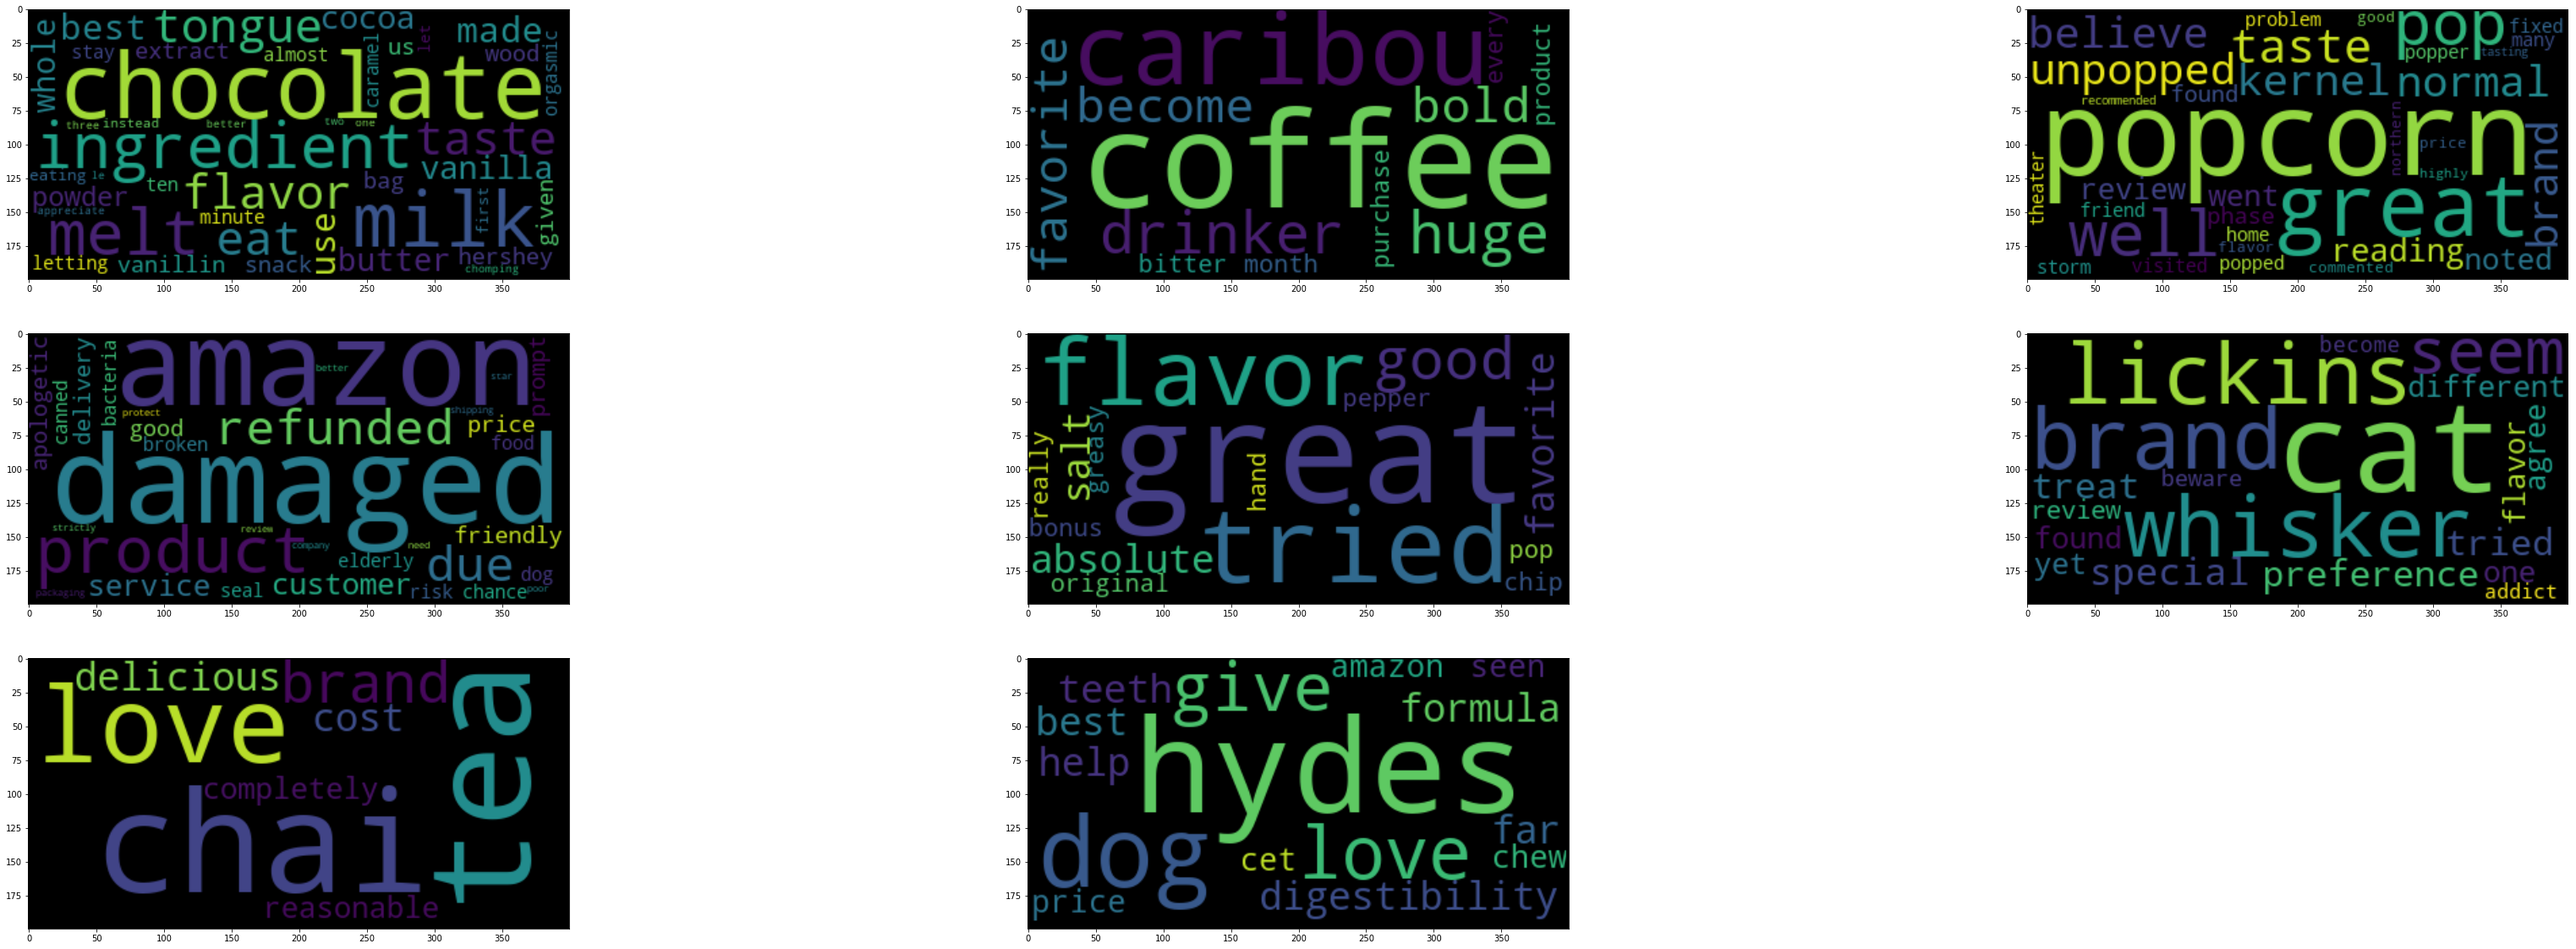

In [69]:
# Please write all the code with proper documentation
plt.figure(figsize=(60,20))
plt.subplot(3, 3, 1)
   
wordcloud = WordCloud().generate(groups[0])


plt.imshow(wordcloud, interpolation='bilinear')
    
    
plt.subplot(3, 3, 2)
    
wordcloud = WordCloud().generate(groups[1])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 3)
    
wordcloud = WordCloud().generate(groups[2])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 4)
    
    
wordcloud = WordCloud().generate(groups[3])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 5)
    
     
wordcloud = WordCloud().generate(groups[4])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 6)
    
     
wordcloud = WordCloud().generate(groups[5])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3,7)
    
    
wordcloud = WordCloud().generate(groups[6])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3,8)
    
    
wordcloud = WordCloud().generate(groups[7])


plt.imshow(wordcloud, interpolation='bilinear')
   

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [88]:
# Please write all the code with proper documentation
i=0
list_of_sentance_train=[]

for sentance in final['clean_text']:
    list_of_sentance_train.append(sentance.split())

In [89]:
import gensim
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
  

In [90]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  11680
sample words  ['dog', 'love', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chance', 'till', 'know', 'going', 'import', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'lover', 'available', 'victor', 'trap', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'thirty', 'buck', 'used', 'bait', 'season', 'ca', 'not', 'beat']


In [91]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(preprocessed_reviews): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

100%|████████████████████████████████████████████████████████████████████████████| 46071/46071 [43:47<00:00, 17.53it/s]


46071
50


In [92]:
%%time
from sklearn.cluster import KMeans


k_inertia=[]

k=[2,4,6,8]
for i in k:

        k_m= KMeans(n_clusters=i,init='k-means++', random_state=0)
        k_m.fit(sent_vectors_tr)
        k_inertia.append(k_m.inertia_)
        print("cluster",i,"done")
    

cluster 2 done
cluster 4 done
cluster 6 done
cluster 8 done
Wall time: 36.8 s


In [93]:
print(k_inertia)

[9212.784487199473, 7339.908800634578, 6447.544550000714, 5917.913682764898]


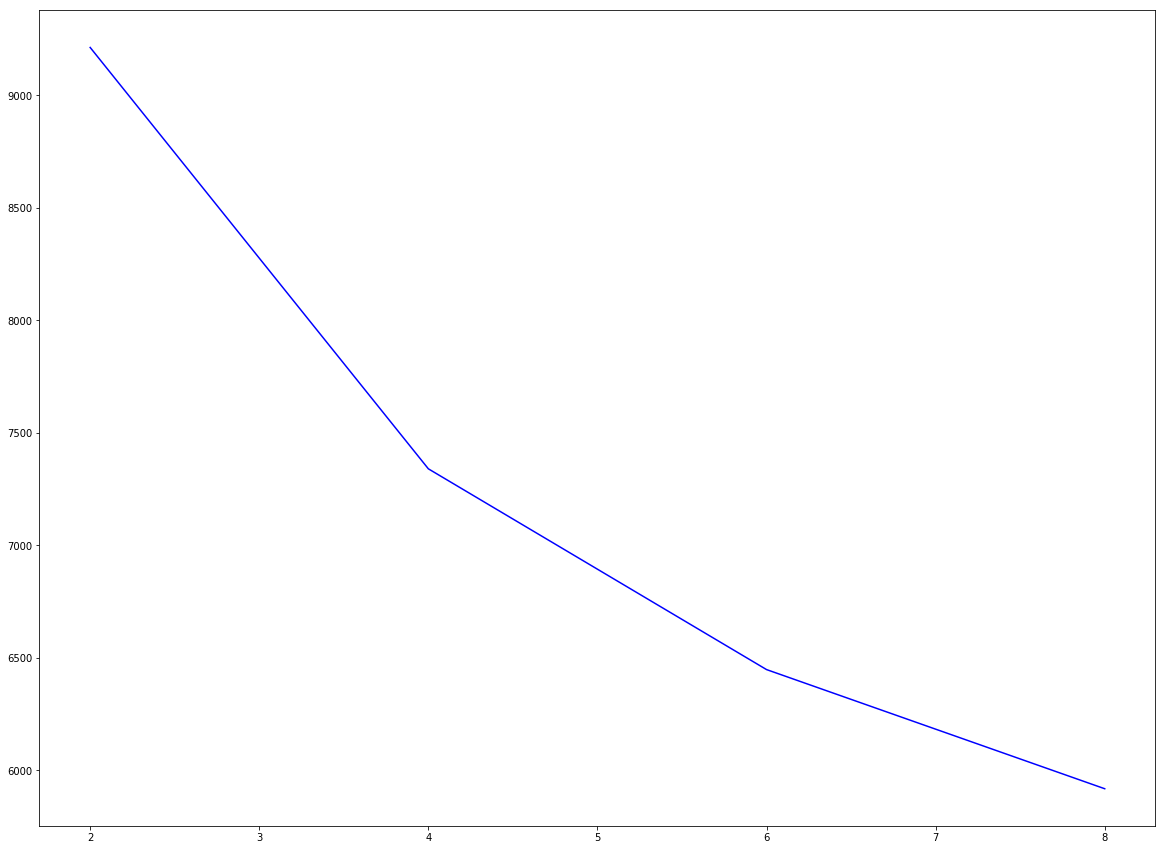

In [94]:
plt.figure(figsize = (20,15))
plt.plot(k,k_inertia,color='blue')

In [95]:
best_k=8

In [96]:
label=KMeans(n_clusters=best_k,init='k-means++', random_state=0).fit(sent_vectors_tr).labels_

In [97]:
final['cluster_no']=label

In [98]:
groups=[]
for i in (np.unique(label)):
    print("cluster  is",i)
    print("****************")
    length_per_cluster=len(final[final['cluster_no']==i])
    print(length_per_cluster)
    rand_ind=np.random.randint(low=0,high=length_per_cluster,size=1)
    for n in rand_ind:
        line=final[final['cluster_no']==i]['clean_text'].iloc[n]
        print(line)
     #print(length_per_cluster)
    groups.append(line)

cluster  is 0
****************
8520
sprouter easy use small quantity sprouted several small chamber fresh sprout constantly really like product use time easy use 
cluster  is 1
****************
2509
c e co founder sprout food inc pickled pantry illegally selling product online also price gouging per pouch product sold marketplace anywhere depending retailer please not waste money buying pickled pantry working removed amazon not order pickled pantry 
cluster  is 2
****************
4844
exactly advertised plenty space set keurig brewer top still fit counter top depending counter top height cup fir nicely drawer easy access see k cup may want k cup holder 
cluster  is 3
****************
4399
first time italy fell love like coffe chocolate got try not go without since get year fall cold season chocolate melt order enough gift year phenomenal 
cluster  is 4
****************
3256
wife drink organic decaf green tea bought surprise love make cup every night not disappointed wife organic green 

In [99]:
groups=[]
for i in (np.unique(label)):
    print("cluster  is",i)
    print("****************")
    length_per_cluster=len(final[final['cluster_no']==i])
    print(length_per_cluster)
    rand_ind=np.random.randint(low=0,high=length_per_cluster,size=3)
    for n in rand_ind:
        line=final[final['cluster_no']==i]['clean_text'].iloc[n]
        print(line)
     #print(length_per_cluster)
    groups.append(line)

cluster  is 0
****************
8520
finding great tasting steel oat cook quickly processed oatmeal not easy oat even microwaved never get gummy originally found california visiting family could not find virginia returned home purchase two big bag minimum getting internet big bag intend share one friend healthy delicious 
good deal better buying local craft store even better online cake supply store item arrived promised useful making spider turkey cupckaes fall baking season good deal 
love love stuff add meat great smokey taste use herb spice brown sugar make super rub bar b q smoked hungarian paprika 
cluster  is 1
****************
2509
son vacation couple year ago brought back hawaii roaster kona coffee different technique way grown coffee thought would check see amazon best tasting coffee ever tasted well worth money smoothest cup coofee ever 
wonderful blend tasty absolutely no bitterness like french roast product shipped time perfect condition fully reccommend coffee nantucket co

In [100]:
print(groups)

['love love stuff add meat great smokey taste use herb spice brown sugar make super rub bar b q smoked hungarian paprika ', 'bought product thought might make good backpacking food not low fat calorie really wanted like product not like taste fact added sugar lot people seem like taste though not unhappy gave try keep try using flavoring cooking not taste like real peanut butter ', 'cat love food money great product get every month cat love flavor great deal ', 'pan ducale almond biscotti disappointment not bad could not come close great lettieri prato belli cantuccini almond cooky best low calorie also almond disappointment ', 'not expected sweet bit candied orange rind garlic really not notice chili chili title expected heat none definitely need heat tasty ', 'nothing gritty second rate good pancake mix use whole family gluten free not good ca not tell difference regular pancake waffle ', 'daughter enjoyed product deli town trip looked area seems no one carry find amazon ordered case

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [101]:
from wordcloud import WordCloud

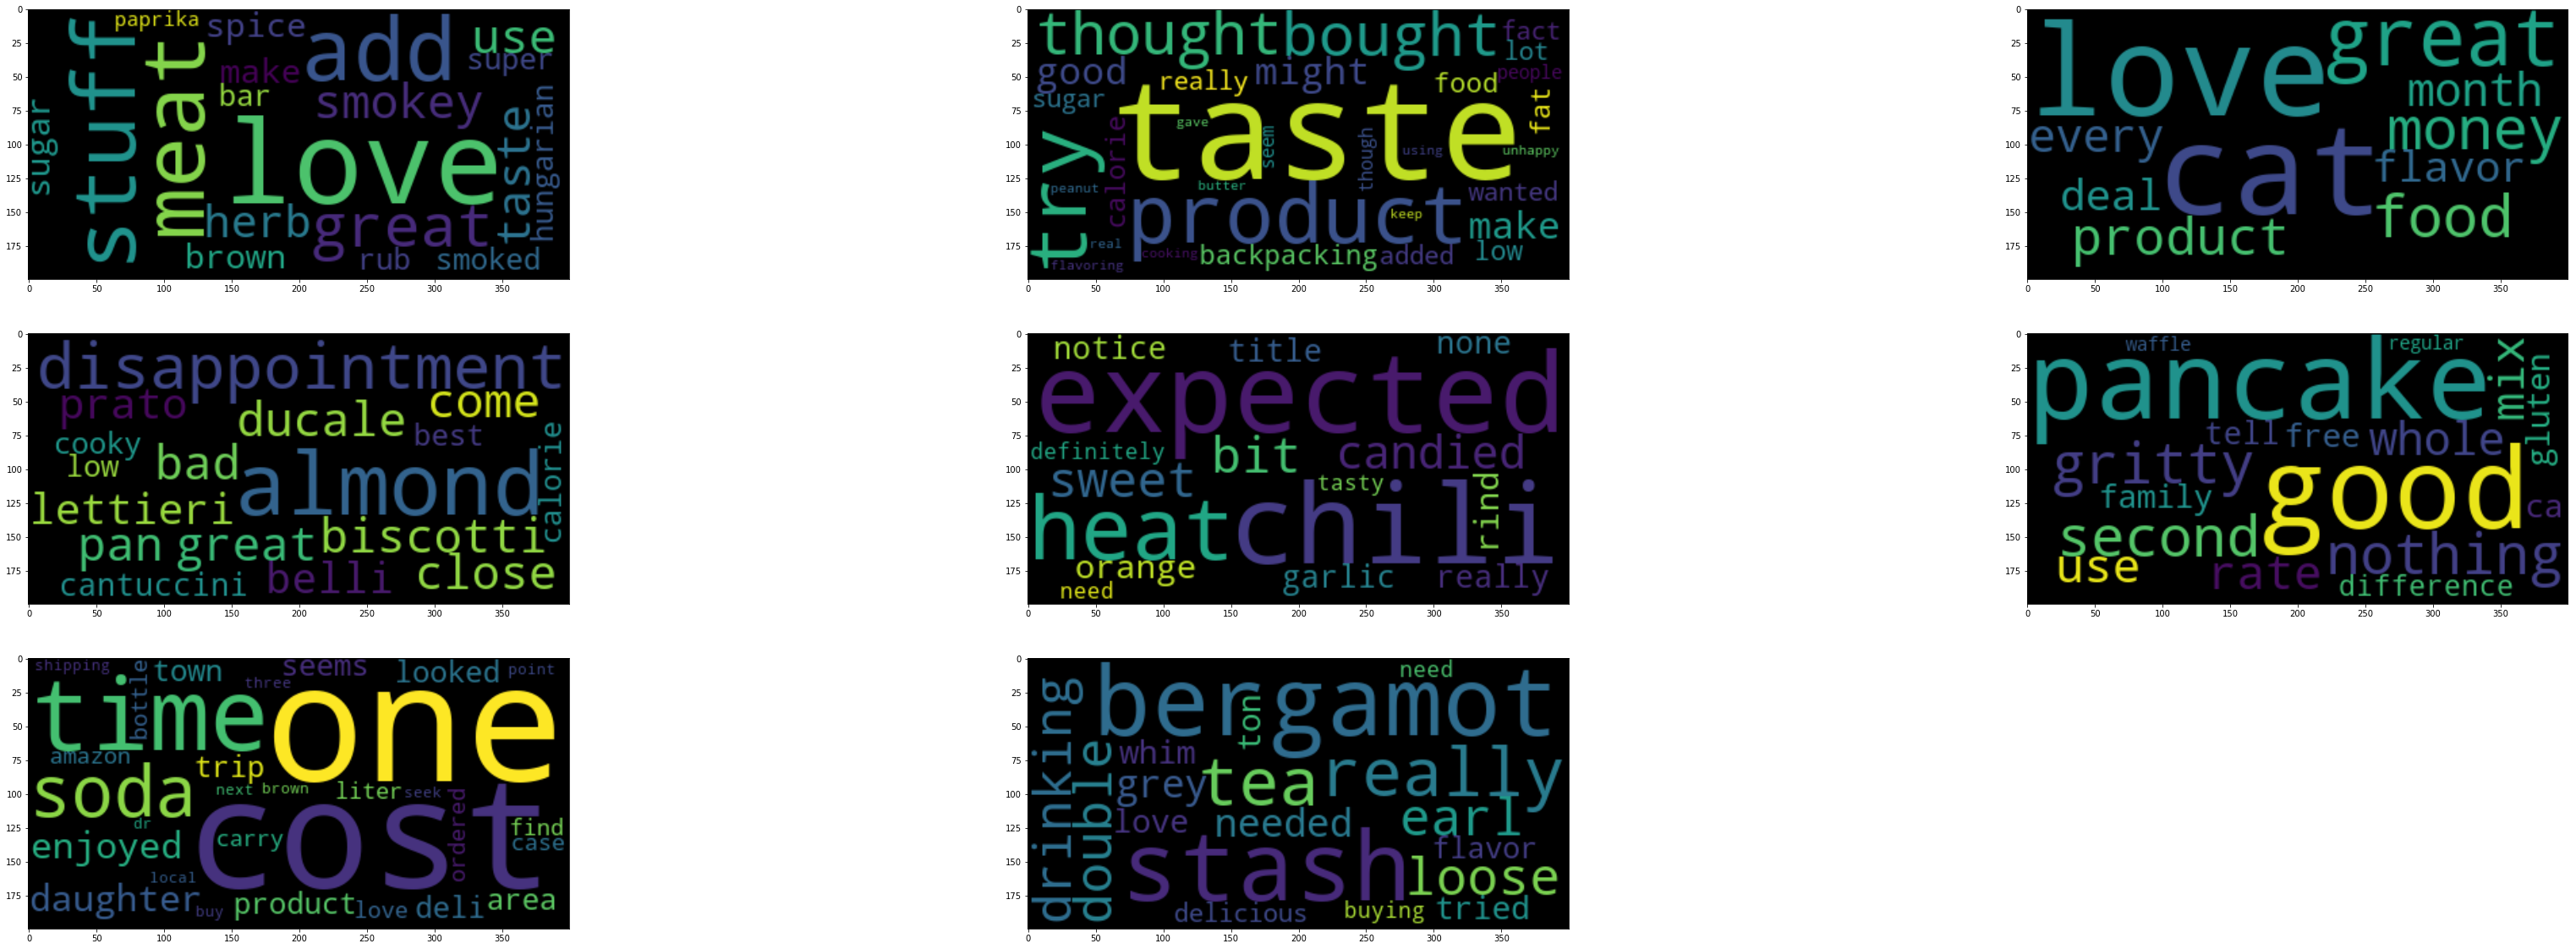

In [102]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
plt.figure(figsize=(60,20))
plt.subplot(3, 3, 1)
   
wordcloud = WordCloud().generate(groups[0])


plt.imshow(wordcloud, interpolation='bilinear')
    
    
plt.subplot(3, 3, 2)
    
wordcloud = WordCloud().generate(groups[1])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 3)
    
wordcloud = WordCloud().generate(groups[2])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 4)
    
    
wordcloud = WordCloud().generate(groups[3])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 5)
    
     
wordcloud = WordCloud().generate(groups[4])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 6)
    
     
wordcloud = WordCloud().generate(groups[5])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3,7)
    
    
wordcloud = WordCloud().generate(groups[6])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3,8)
    
    
wordcloud = WordCloud().generate(groups[7])


plt.imshow(wordcloud, interpolation='bilinear')
   

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [103]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(final['clean_text'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [104]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 46071/46071 [23:15<00:00, 33.02it/s]


In [105]:
%%time
from sklearn.cluster import KMeans


k_inertia=[]

k=[2,4,6,8]
for i in k:

        k_m= KMeans(n_clusters=i,init='k-means++', random_state=0)
        k_m.fit(tfidf_sent_vectors_train)
        k_inertia.append(k_m.inertia_)
        print("cluster",i,"done")
    

cluster 2 done
cluster 4 done
cluster 6 done
cluster 8 done
Wall time: 24.9 s


In [106]:
print(k_inertia)

[502845.1763052607, 421951.1741810469, 384382.69464861375, 357544.4942829894]


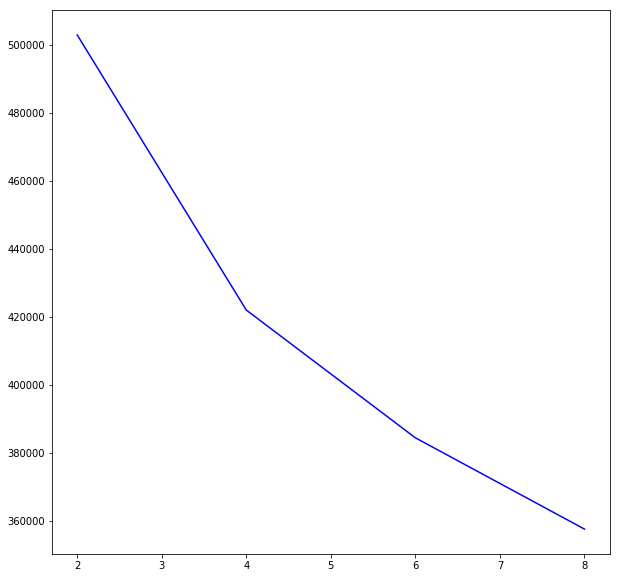

In [107]:
plt.figure(figsize = (10,10))
plt.plot(k,k_inertia,color='blue')

In [108]:
best_k=8

In [109]:
label=KMeans(n_clusters=best_k,init='k-means++', random_state=0).fit(tfidf_sent_vectors_train).labels_

In [110]:
final['cluster_no']=label

In [111]:
#Reference:https://www.youtube.com/watch?v=IxBYhjS295w
groups=[]
for i in (np.unique(label)):
    print("cluster  is",i)
    print("****************")
    length_per_cluster=len(final[final['cluster_no']==i])
    print(length_per_cluster)
    rand_ind=np.random.randint(low=0,high=length_per_cluster,size=3)
    for n in rand_ind:
        line=final[final['cluster_no']==i]['clean_text'].iloc[n]
        print(line)
     #print(length_per_cluster)
    groups.append(line)

cluster  is 0
****************
3567
coffee tasted bitter burnt not like cup kept open mind cup not better wish could return remaining cup one star fast shipment not happy 
tried almost kicking horse coffee find medium roast strong enough buy organic coffee organic brewed orgasmic bean higher price like quality rotten coffee pay good coffee good coffee 
sampling every k cup say caribou blend best one daily regular coffee drinker not huge fan flavored coffee nor love dark bitter bold type simply want smooth cup joe drink daily feel comforted consistently tasting awesome caribou perfect fit would go far say brewing caribou k cup home kept going starbucks month taste better caribou win hand 
cluster  is 1
****************
12999
excited decided buy bag huge price great love coach oat go oatmeal 
purchased yummy treat whim wow ever hooked sent e mail company could not find anywhere desperate measure guess cherry vanilla top try flavor try like amazing addicting 
cheaper coffee probably tried

In [112]:
print(groups)

['sampling every k cup say caribou blend best one daily regular coffee drinker not huge fan flavored coffee nor love dark bitter bold type simply want smooth cup joe drink daily feel comforted consistently tasting awesome caribou perfect fit would go far say brewing caribou k cup home kept going starbucks month taste better caribou win hand ', 'cheaper coffee probably tried good percentage always end coming back folgers something natural maybe used price folgers vary greatly store deal better amazon would recommend price best part waking ', 'really good tried one not sure taste similar yummy ', 'like kettle chip really disappointed order cooked bought bigger sized bag costco chip cooked perfectly not know different never buy chip chip bag cooked ', 'tough mental challenge dog lb mostly dingo mix strategy pick bottle let drop rope rope hit ground kibbled treat released tough figure however many different feeding toy not give dog love ', 'never tried tea keurig happy flavor good way star

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

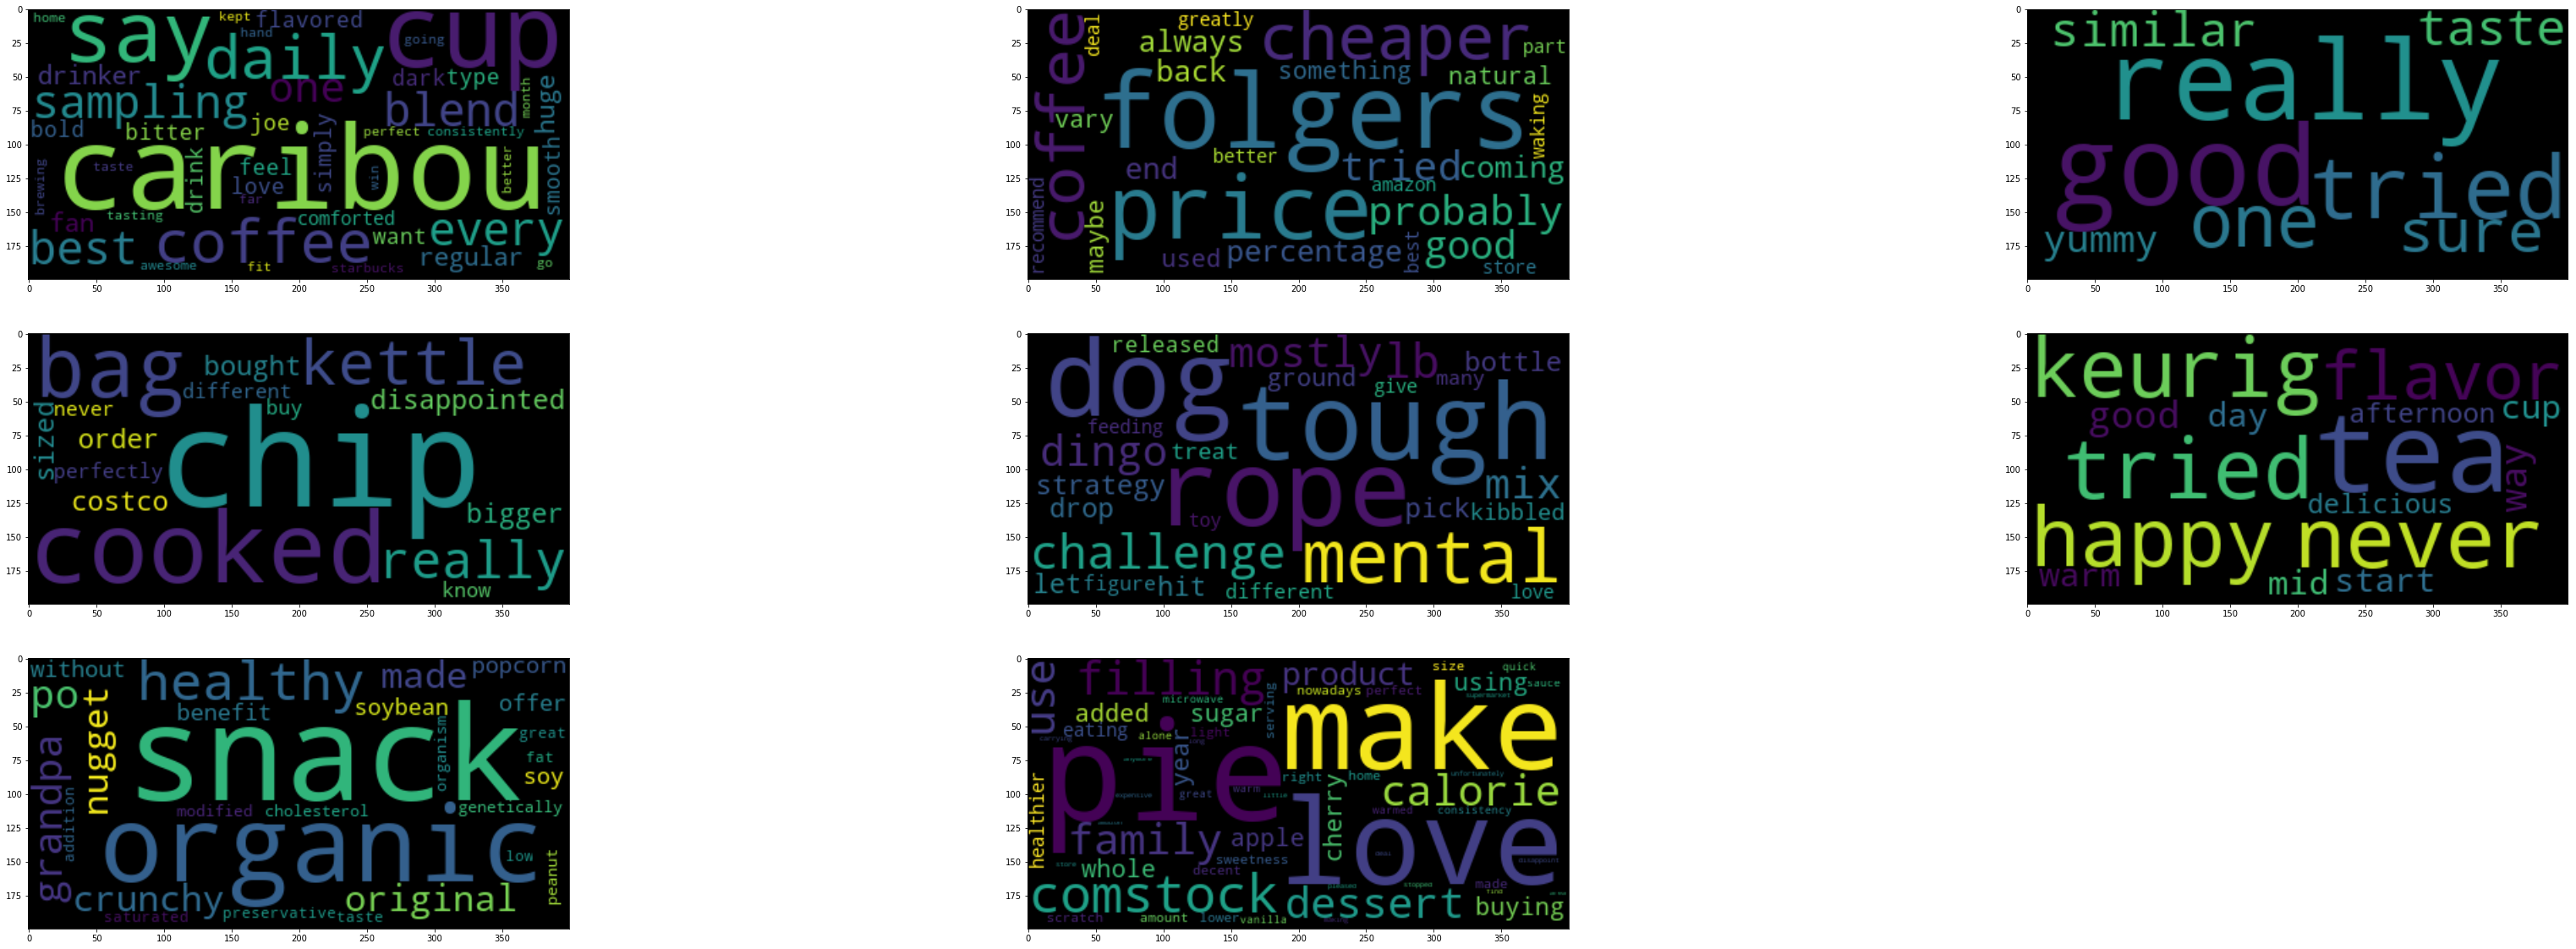

In [113]:
# Please write all the code with proper documentation
plt.figure(figsize=(60,20))
plt.subplot(3, 3, 1)
   
wordcloud = WordCloud().generate(groups[0])


plt.imshow(wordcloud, interpolation='bilinear')
    
    
plt.subplot(3, 3, 2)
    
wordcloud = WordCloud().generate(groups[1])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 3)
    
wordcloud = WordCloud().generate(groups[2])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 4)
    
    
wordcloud = WordCloud().generate(groups[3])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 5)
    
     
wordcloud = WordCloud().generate(groups[4])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 6)
    
     
wordcloud = WordCloud().generate(groups[5])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3,7)
    
    
wordcloud = WordCloud().generate(groups[6])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3,8)
    
    
wordcloud = WordCloud().generate(groups[7])


plt.imshow(wordcloud, interpolation='bilinear')
   

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [118]:
%%time
from sklearn.cluster import AgglomerativeClustering


ag_inertia=[]

k=[2,4,6,8]
for i in k:

        ag= AgglomerativeClustering(n_clusters=i)
        ag.fit(sent_vectors_tr)
        label=ag.labels_
        print("cluster",i,"done")
    

cluster 2 done
cluster 4 done
cluster 6 done
cluster 8 done
Wall time: 7.5 s


In [121]:
print(np.unique(label))

[0 1 2 3 4 5 6 7]


In [ ]:
final['cluster_no']=label

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

In [122]:
# Please write all the code with proper documentation
groups=[]
for i in (np.unique(label)):
    print("cluster  is",i)
    print("****************")
    length_per_cluster=len(final[final['cluster_no']==i])
    print(length_per_cluster)
    rand_ind=np.random.randint(low=0,high=length_per_cluster,size=1)
    for n in rand_ind:
        line=final[final['cluster_no']==i]['clean_text'].iloc[n]
        print(line)
     #print(length_per_cluster)
    groups.append(line)

cluster  is 0
****************
301
can not express enough pleased dog food feed year old german shepard two year old pittie girl food every day benefit astounding shepard life fed well known vet recommended food yet always stomach problem trying many thing not rescued really say rescued dog food recall began research brand food long investigation decided newman not no recall food ingredient proceeds going charity choosing brand would mean would order online local store not carry right not enjoy online ordering older disabled woman getting store hauling package hard well want tell year old thrives food no digestive issue beautiful white coat love eating vigor two year old american pit bull terrier another love life also thrives food beautiful shiny coat ever people say time beautiful coat spoil fur kid health well number one priority recently switched feeding cat newman cat food dry canned food since noticed difference elimination hair ball know truly pet lover believe love pet want bes

In [123]:
print(groups)

['can not express enough pleased dog food feed year old german shepard two year old pittie girl food every day benefit astounding shepard life fed well known vet recommended food yet always stomach problem trying many thing not rescued really say rescued dog food recall began research brand food long investigation decided newman not no recall food ingredient proceeds going charity choosing brand would mean would order online local store not carry right not enjoy online ordering older disabled woman getting store hauling package hard well want tell year old thrives food no digestive issue beautiful white coat love eating vigor two year old american pit bull terrier another love life also thrives food beautiful shiny coat ever people say time beautiful coat spoil fur kid health well number one priority recently switched feeding cat newman cat food dry canned food since noticed difference elimination hair ball know truly pet lover believe love pet want best well unnecessary medical issue 

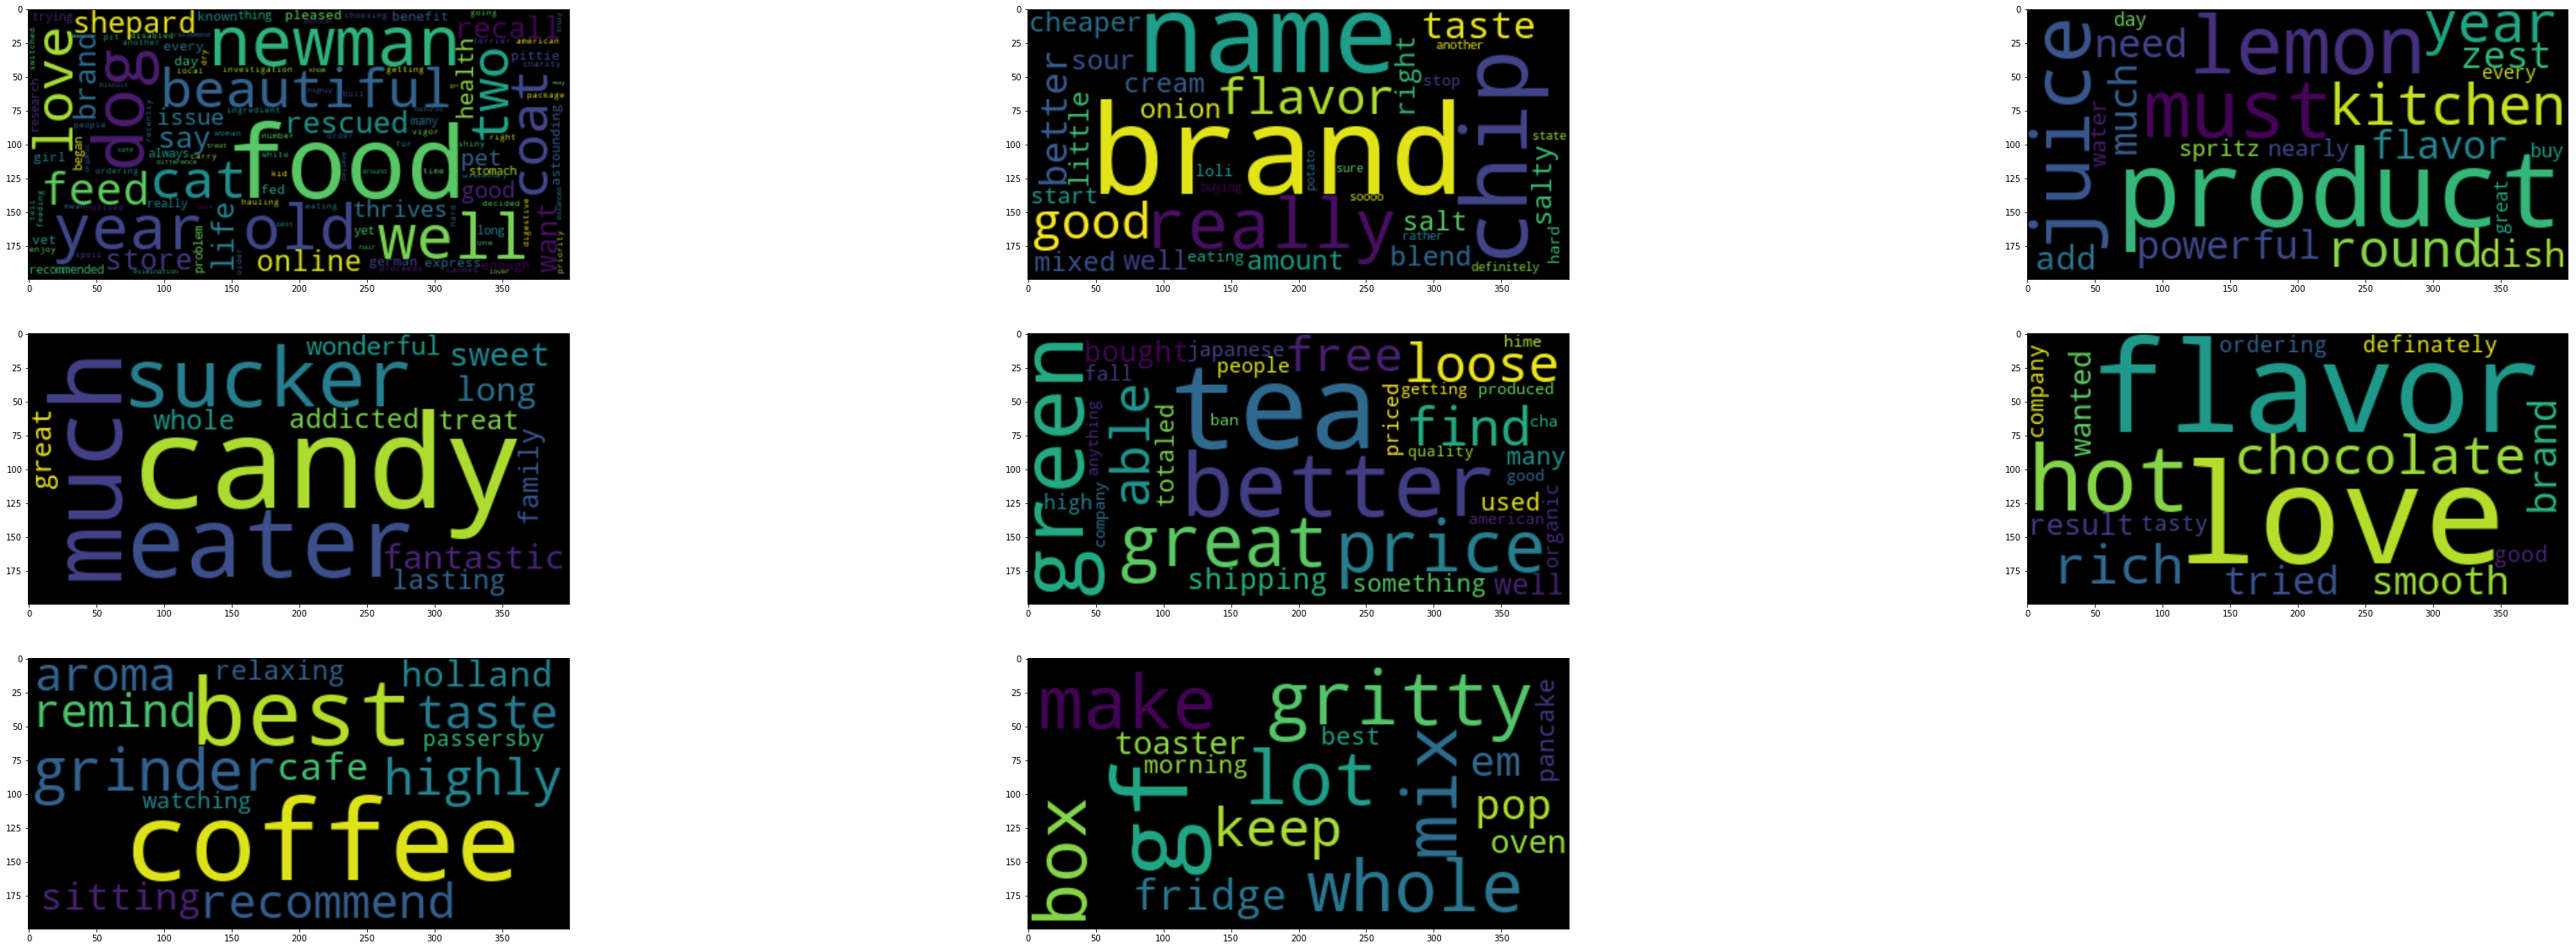

In [124]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
plt.figure(figsize=(60,20))
plt.subplot(3, 3, 1)
   
wordcloud = WordCloud().generate(groups[0])


plt.imshow(wordcloud, interpolation='bilinear')
    
    
plt.subplot(3, 3, 2)
    
wordcloud = WordCloud().generate(groups[1])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 3)
    
wordcloud = WordCloud().generate(groups[2])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 4)
    
    
wordcloud = WordCloud().generate(groups[3])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 5)
    
     
wordcloud = WordCloud().generate(groups[4])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 6)
    
     
wordcloud = WordCloud().generate(groups[5])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3,7)
    
    
wordcloud = WordCloud().generate(groups[6])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3,8)
    
    
wordcloud = WordCloud().generate(groups[7])


plt.imshow(wordcloud, interpolation='bilinear')
   

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [104]:

%%time
from sklearn.cluster import AgglomerativeClustering


ag_inertia=[]

k=[2,4,6,8]
for i in k:

        ag= AgglomerativeClustering(n_clusters=i)
        ag.fit(tfidf_sent_vectors_train)
        label=ag.labels_
        print("cluster",i,"done")
    

cluster 2 done
cluster 4 done
cluster 6 done
cluster 8 done
Wall time: 8.49 s


In [ ]:
final['cluster_no']=label

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

In [105]:
# Please write all the code with proper documentation
groups=[]
for i in (np.unique(label)):
    print("cluster  is",i)
    print("****************")
    length_per_cluster=len(final[final['cluster_no']==i])
    print(length_per_cluster)
    rand_ind=np.random.randint(low=0,high=length_per_cluster,size=1)
    for n in rand_ind:
        line=final[final['cluster_no']==i]['clean_text'].iloc[n]
        print(line)
     #print(length_per_cluster)
    groups.append(line)

cluster  is 0
****************
210
drink lot flavored black tea hand one favorite scent enticing flavor bold sweet time love spice must tea delicious tea 
cluster  is 1
****************
1499
super tasty quick meal bit small perfect lunch go definitely not going help dinner hunger pang though sodium little higher would like really not beat economic efficient lunchfood love 
cluster  is 2
****************
964
looooove pocky got lucky couldnt stop like chocolate laced crack anywho product good sad thing shipped stored hot room chocolate melted together partially didnt take much effort take apart stick great product great price merchant awsome 
cluster  is 3
****************
218
one purchase product called newman organic one would expect organic food not vegetable much le expensive organic meat chicken disappointed find chicken not organic couple dollar buy real organic dog food dog food not exactly cheap expect provide advertising whole greenwashing thing need regulated better someone us 

In [106]:
print(groups)

['drink lot flavored black tea hand one favorite scent enticing flavor bold sweet time love spice must tea delicious tea ', 'super tasty quick meal bit small perfect lunch go definitely not going help dinner hunger pang though sodium little higher would like really not beat economic efficient lunchfood love ', 'looooove pocky got lucky couldnt stop like chocolate laced crack anywho product good sad thing shipped stored hot room chocolate melted together partially didnt take much effort take apart stick great product great price merchant awsome ', 'one purchase product called newman organic one would expect organic food not vegetable much le expensive organic meat chicken disappointed find chicken not organic couple dollar buy real organic dog food dog food not exactly cheap expect provide advertising whole greenwashing thing need regulated better someone us word organic description better organic otherwise consumer deceived unfortunate newman great reputation buy lot product intentiona

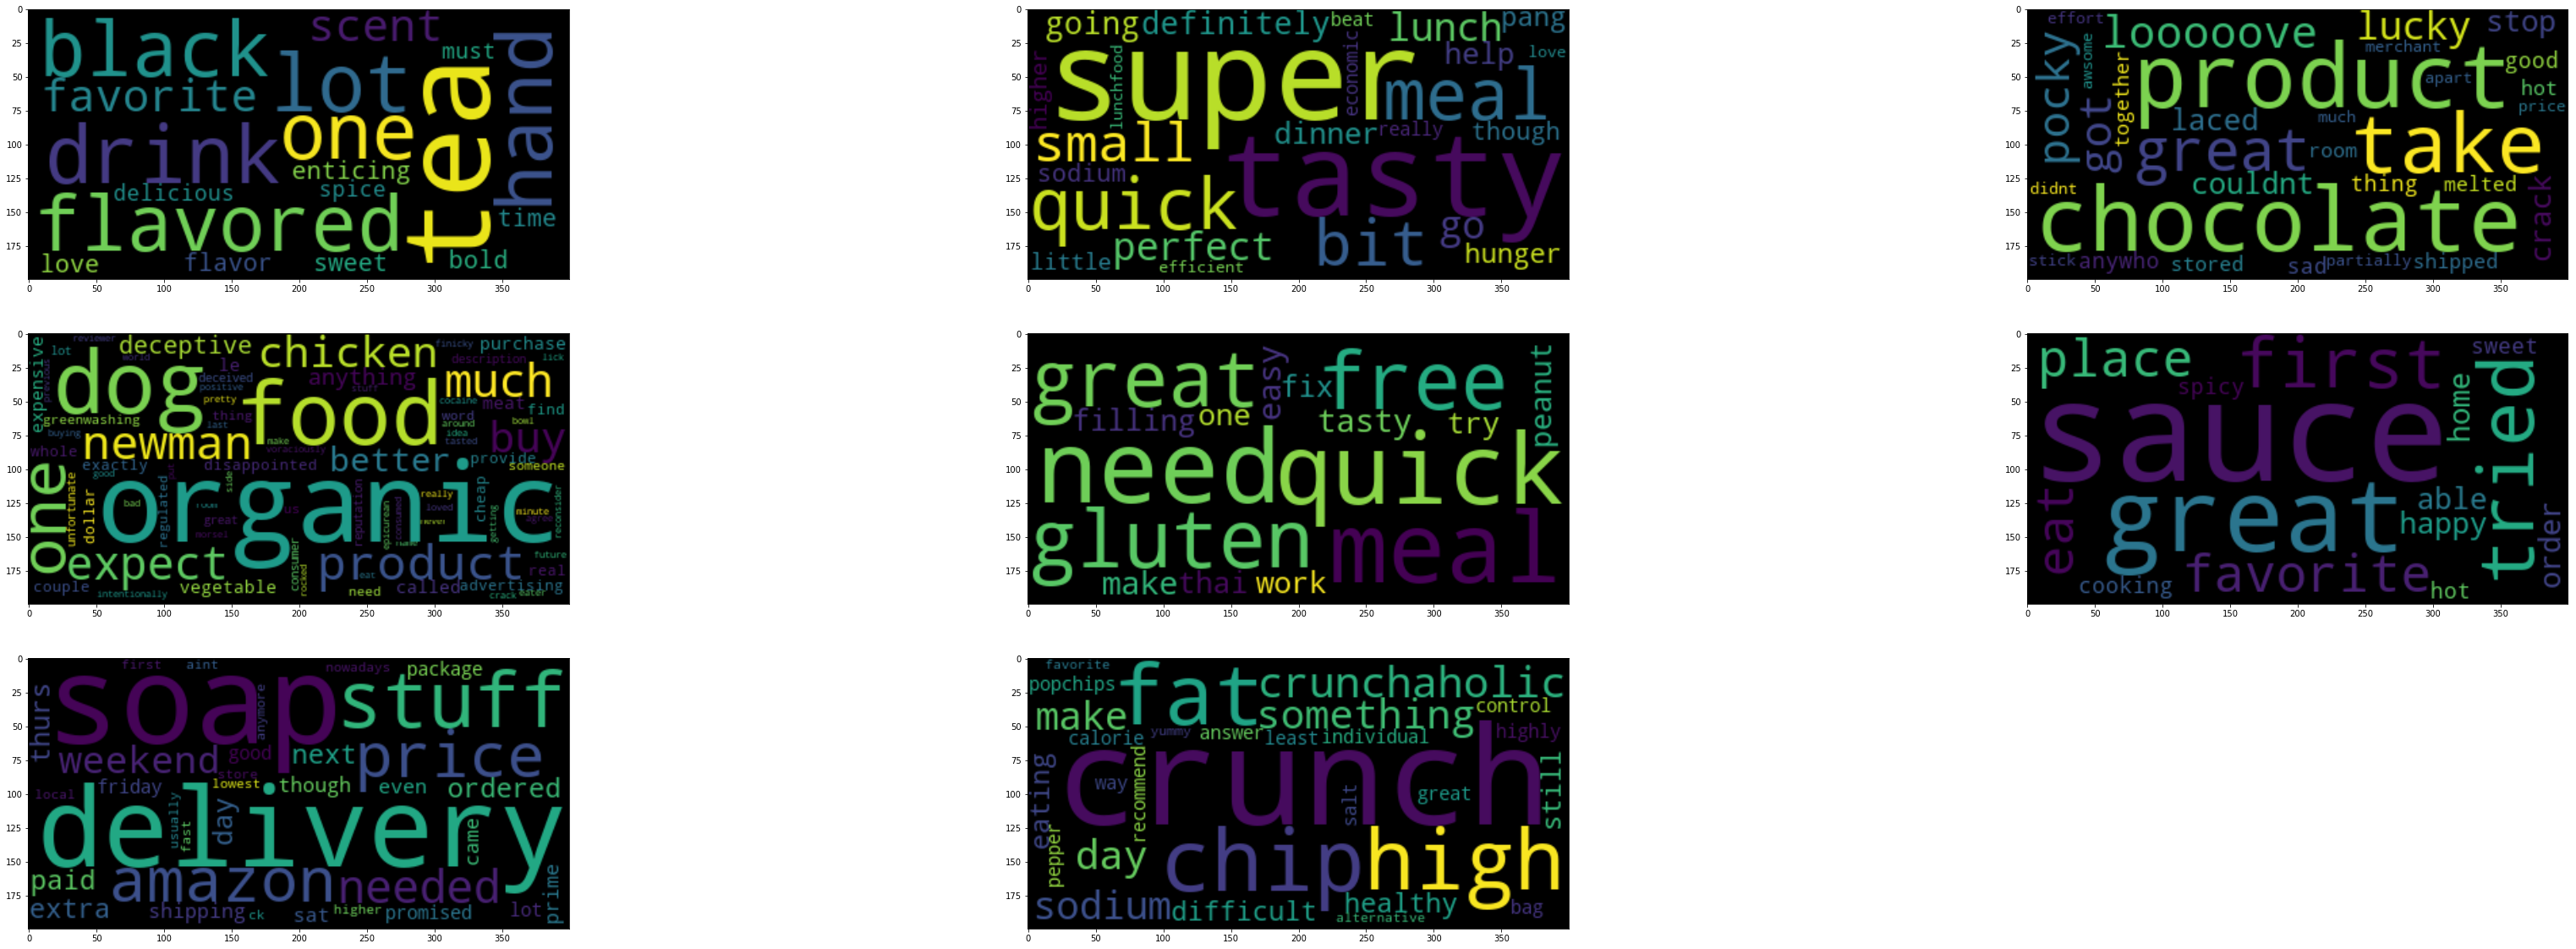

In [107]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
plt.figure(figsize=(60,20))
plt.subplot(3, 3, 1)
   
wordcloud = WordCloud().generate(groups[0])


plt.imshow(wordcloud, interpolation='bilinear')
    
    
plt.subplot(3, 3, 2)
    
wordcloud = WordCloud().generate(groups[1])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 3)
    
wordcloud = WordCloud().generate(groups[2])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 4)
    
    
wordcloud = WordCloud().generate(groups[3])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 5)
    
     
wordcloud = WordCloud().generate(groups[4])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3, 6)
    
     
wordcloud = WordCloud().generate(groups[5])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3,7)
    
    
wordcloud = WordCloud().generate(groups[6])


plt.imshow(wordcloud, interpolation='bilinear')
plt.subplot(3, 3,8)
    
    
wordcloud = WordCloud().generate(groups[7])


plt.imshow(wordcloud, interpolation='bilinear')
   

In [3]:
# Please write all the code with proper documentation

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [36]:
i=0
list_of_sentance_train=[]

for sentance in final['clean_text']:
    list_of_sentance_train.append(sentance.split())

In [37]:
import gensim
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
  

In [38]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3629
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumb', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'sticker', 'removed', 'easily', 'daughter', 'designed', 'sign', 'printed', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'screen', 'computer', 'monitor', 'wow', 'make', 'mae', 'ploy', 'sweet', 'chili']


In [39]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(preprocessed_reviews): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

100%|██████████████████████████████████████████████████████████████████████████████| 4986/4986 [01:14<00:00, 67.28it/s]


4986
50


([<matplotlib.axis.XTick at 0x20b66ecfac8>,
 <a list of 104 Text xticklabel objects>)

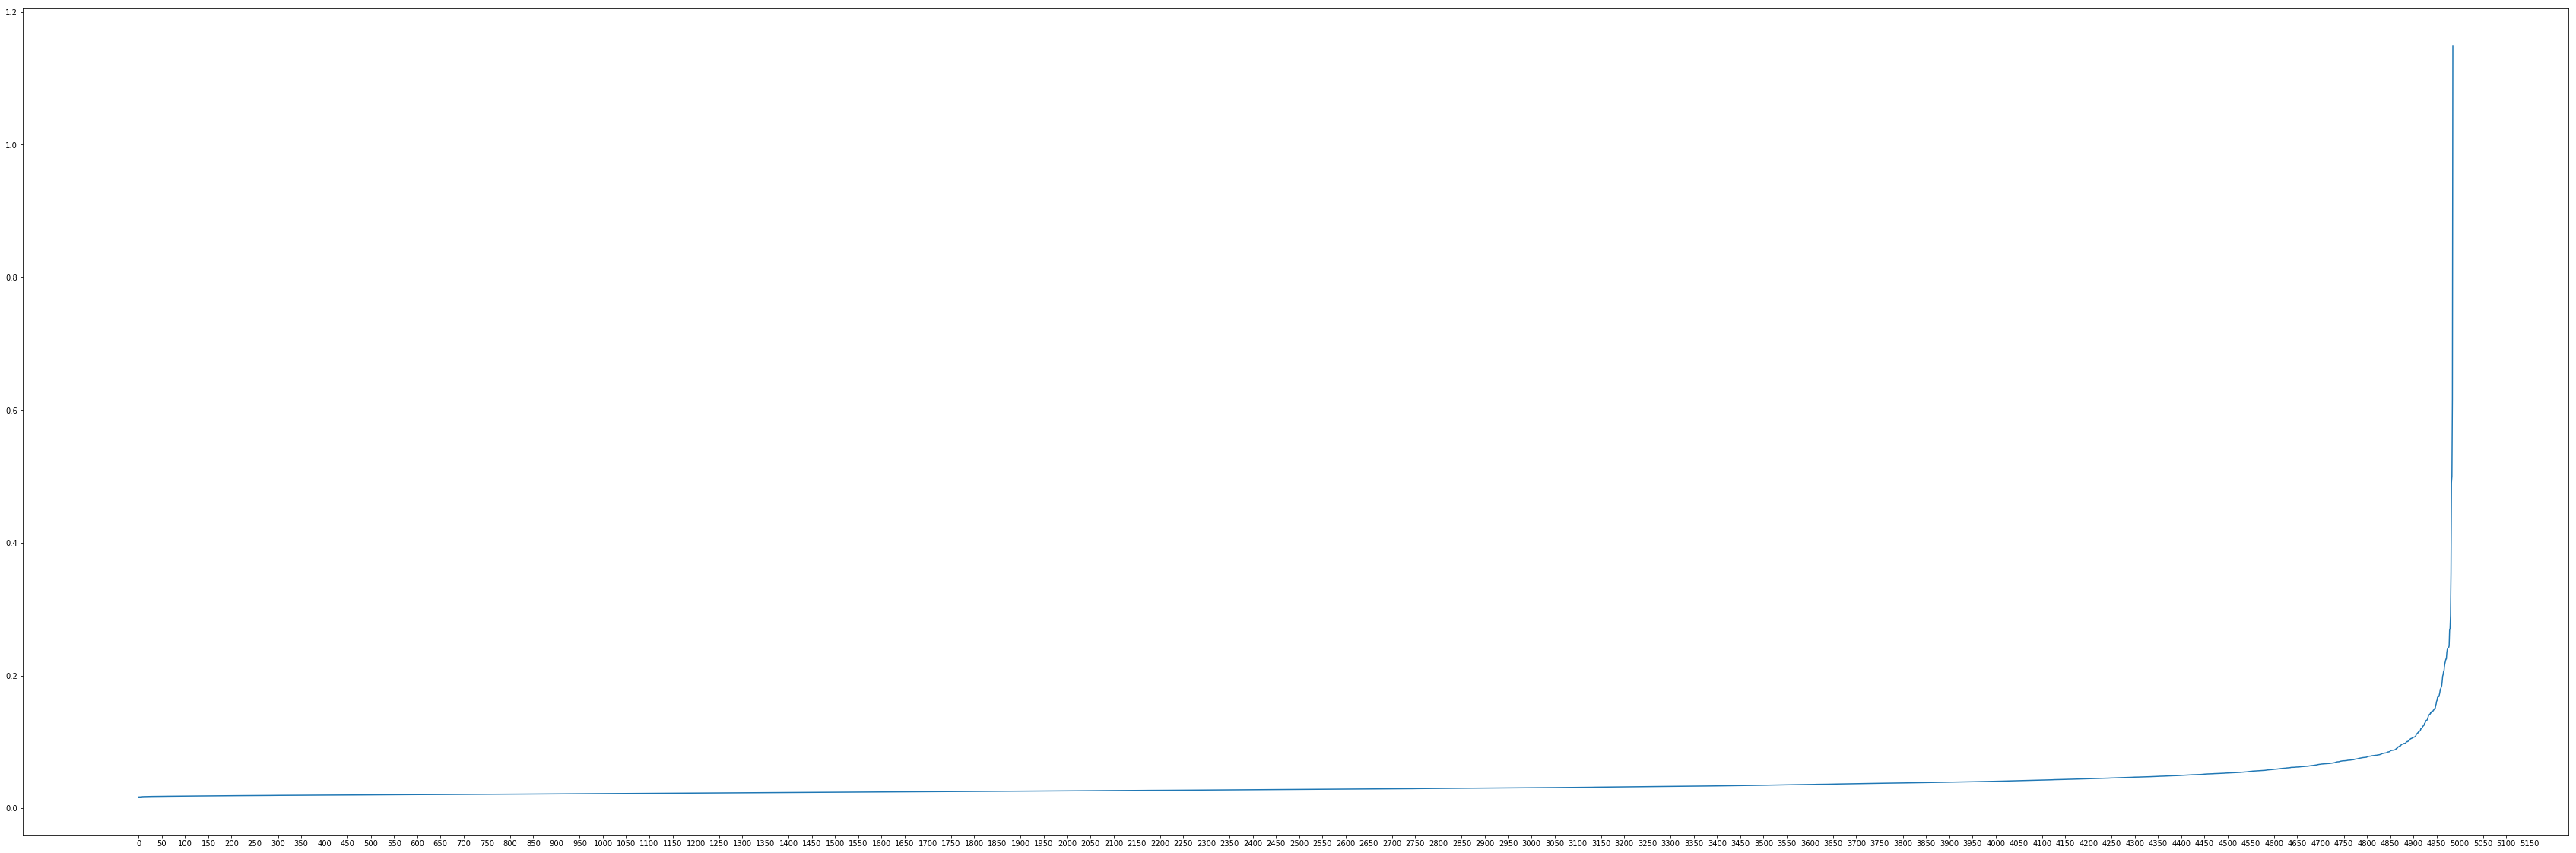

In [40]:
#Reference:https://www.programcreek.com/python/example/85914/sklearn.neighbors.NearestNeighbors
#Reference:https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors
##### Please write all the code with proper documentation
from sklearn.neighbors import NearestNeighbors
min_points=100
near_points=NearestNeighbors(n_neighbors=min_points)
near_points_model=near_points.fit(sent_vectors_tr)
distance,index=near_points_model.kneighbors(sent_vectors_tr)
x=np.arange(distance.shape[0])
bucket=[]
for i in x:
    
    y=distance[i].mean()
    bucket.append(y)
    
sorted_bucket=np.sort(bucket)
plt.figure(figsize=(60,20))
plt.plot(x,sorted_bucket)
plt.xticks(np.arange(0, 5200, 50))

In [41]:
eps=0.2
min_points=100

In [67]:
from sklearn.cluster import DBSCAN
model=DBSCAN(eps=0.1,min_samples=20)
fit_model=model.fit(sent_vectors_tr)
label=fit_model.labels_

In [57]:
label=label+7

In [68]:
print(label)

[0 0 0 ... 0 0 0]


In [69]:
print(np.unique(label))

[-1  0]


In [70]:
final['cluster_no']=label

In [71]:
print(label)

[0 0 0 ... 0 0 0]


The above code is just done to create one cluster which doen't have outliers

Thus,it cluster the sentences which are closer into one cluster and others are treated as outliers

In [72]:
# Please write all the code with proper documentation
groups=[]
for i in (np.unique(label)):
    
    print("cluster  is",i)
    print("****************")
    length_per_cluster=len(final[final['cluster_no']==i])
    print(length_per_cluster)
    rand_ind=np.random.randint(low=0,high=length_per_cluster,size=5)
    for n in rand_ind:
        line=final[final['cluster_no']==i]['clean_text'].iloc[n]
        print(line)
     #print(length_per_cluster)
    groups.append(line)

cluster  is -1
****************
25
italian lived italy year used buy cooky everyday breakfast italian espresso could not find anywhere bay area great great cooky 
member family need avoid wheat product like even regular bisquick mix make pancake taste closer scratch wheat flour pancake member family not tried yet not used pizza crust biscuit perfect pancake 
discover mix amazon always bought whole food store like mix pancake came delicious fluffy one small secret try add seltzer water instead regular one delisious pancake 
always pleased amazon packaging chip never crushed broken always fresh really liked brand flavor chip tasty great chip 
add growing list review regarding window usb audio device error figured chance working not window insists loading usb driver not work review giving detail possibly circumvent loading process however not work easier return thing spend whole weekend jerking around window hardware manager blue probably good product probably blame window issue however b

In [73]:
print(groups)

['add growing list review regarding window usb audio device error figured chance working not window insists loading usb driver not work review giving detail possibly circumvent loading process however not work easier return thing spend whole weekend jerking around window hardware manager blue probably good product probably blame window issue however blue provide driver work not rely window corporate laziness spend resource programming something work window make available support website make true plug play not plug cross finger spend hour messing around weed window setting also agree review day spent product plastic part feel cheap fragile gain button poorly thought hey blue business lost moving something else window usb issue ', 'bought dog food initally like everything tried newman product human thought pug chloe may like newman also well sure no turning nose get delivered regualry negates need make special trip get dog food update last two bag recieved mite food caused dog severe bo

In [75]:
from wordcloud import WordCloud

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

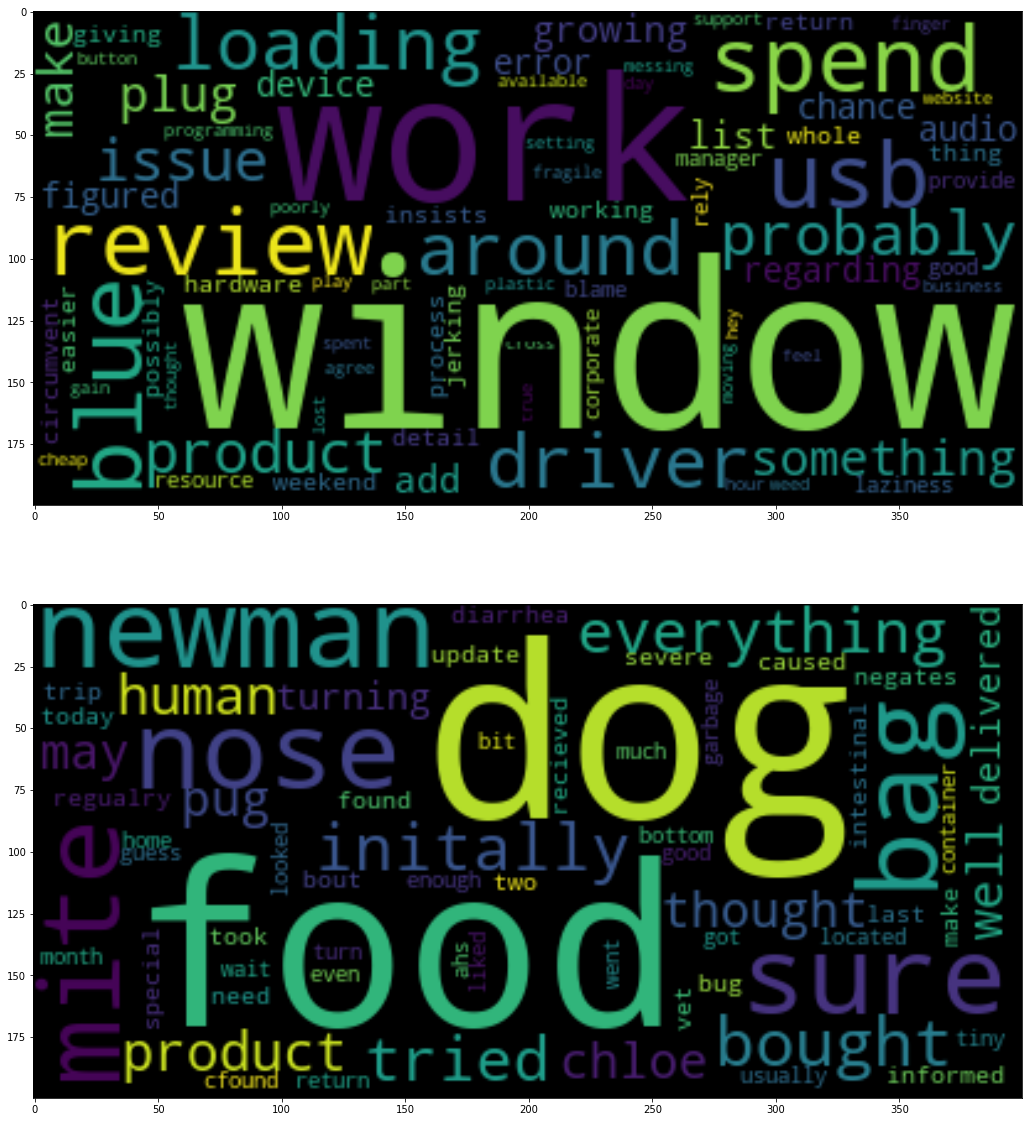

In [76]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
plt.figure(figsize=(60,20))
plt.subplot(2, 1, 1)
   
wordcloud = WordCloud().generate(groups[0])


plt.imshow(wordcloud, interpolation='bilinear')
    
    
plt.subplot(2, 1, 2)
    
wordcloud = WordCloud().generate(groups[1])


plt.imshow(wordcloud, interpolation='bilinear')


In [2]:
# Please write all the code with proper documentation

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [77]:
# Please write all the code with proper documentation
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(final['clean_text'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [78]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:42<00:00, 117.70it/s]


([<matplotlib.axis.XTick at 0x20b67bf52e8>,
 <a list of 104 Text xticklabel objects>)

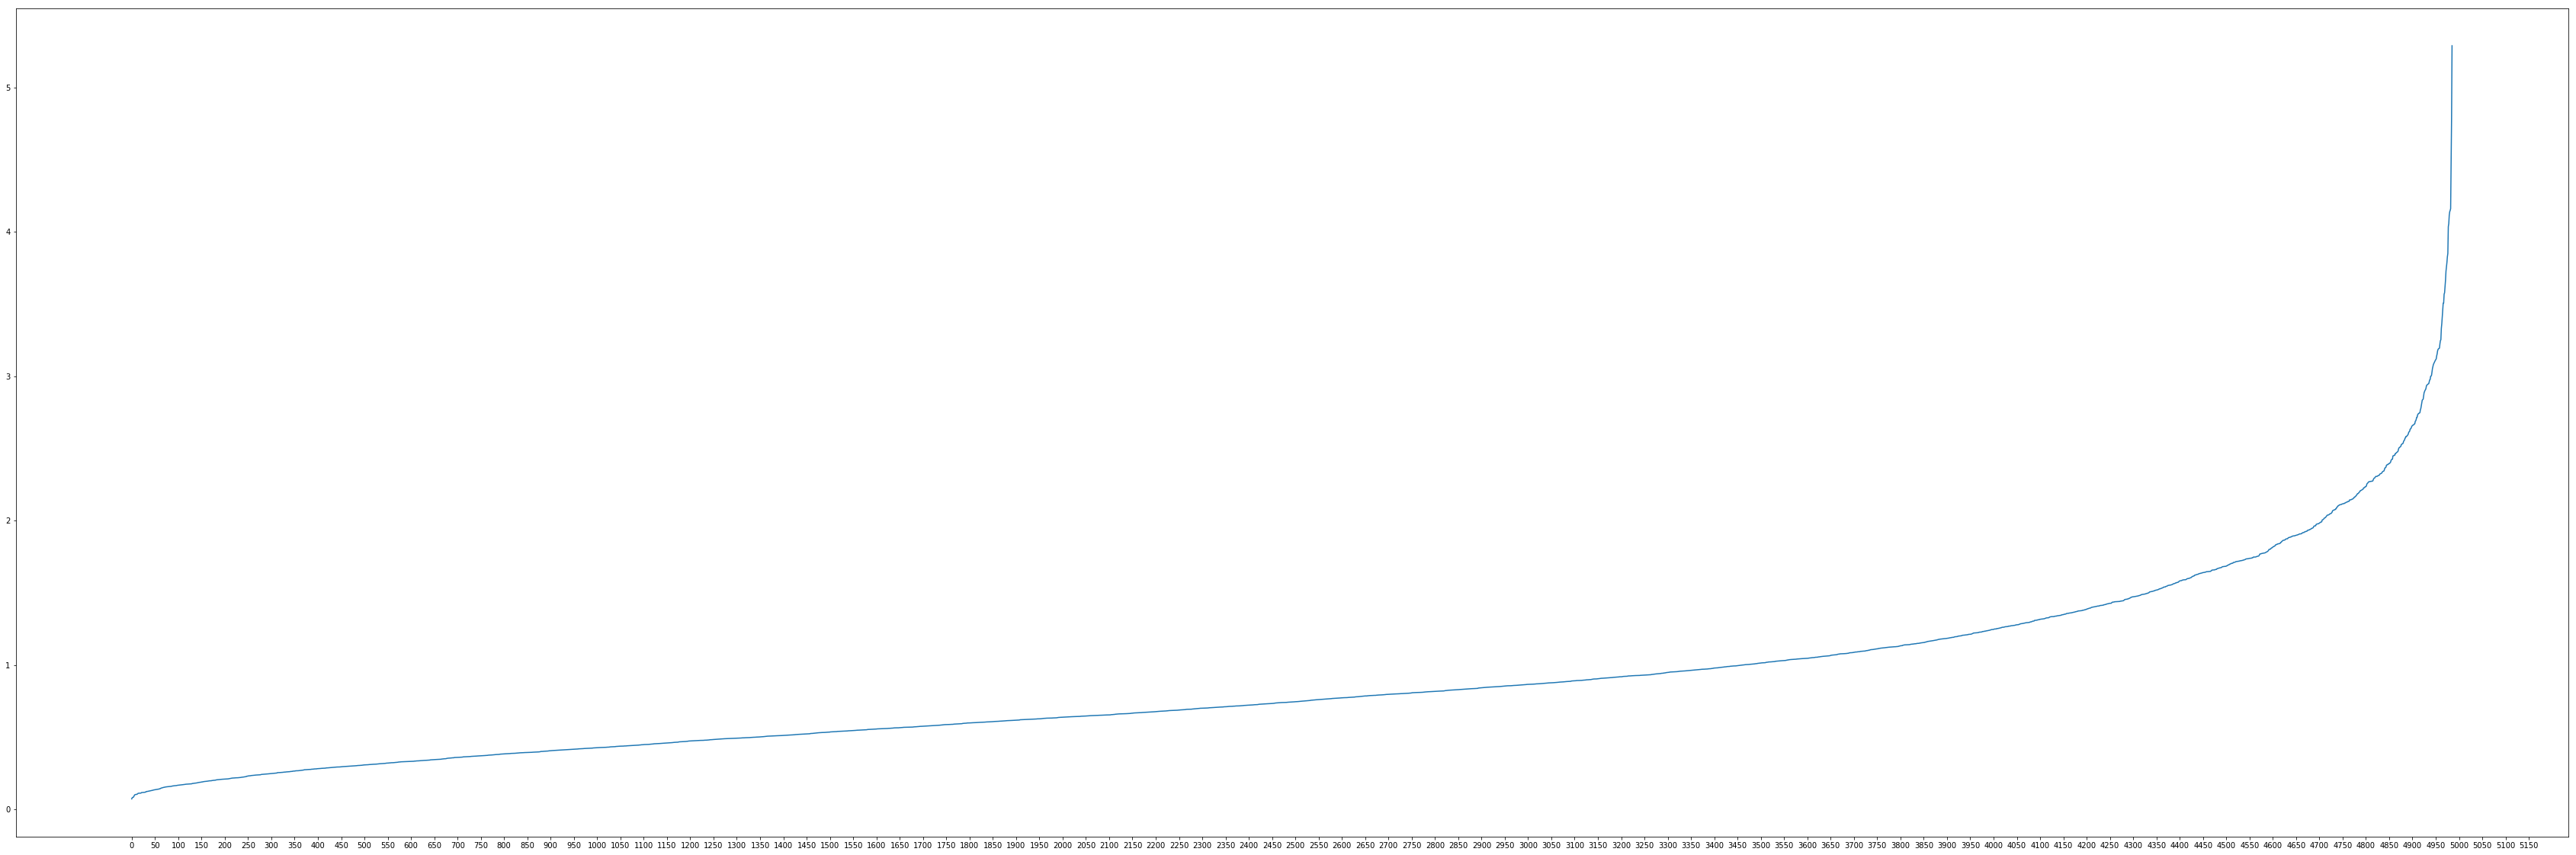

In [80]:
#Reference:https://www.programcreek.com/python/example/85914/sklearn.neighbors.NearestNeighbors
#Reference:https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors
##### Please write all the code with proper documentation
from sklearn.neighbors import NearestNeighbors
min_points=100
near_points=NearestNeighbors(n_neighbors=min_points)
near_points_model=near_points.fit(sent_vectors_tr)
distance,index=near_points_model.kneighbors(tfidf_sent_vectors_train)
x=np.arange(distance.shape[0])
bucket=[]
for i in x:
    
    y=distance[i].mean()
    bucket.append(y)
    
sorted_bucket=np.sort(bucket)
plt.figure(figsize=(60,20))
plt.plot(x,sorted_bucket)
plt.xticks(np.arange(0, 5200, 50))

In [92]:
from sklearn.cluster import DBSCAN
model=DBSCAN(eps=3,min_samples=40)
fit_model=model.fit(tfidf_sent_vectors_train)
label=fit_model.labels_

In [93]:
final['cluster_no']=label

In [100]:
# Please write all the code with proper documentation
groups=[]
for i in (np.unique(label)):
    
    print("cluster  is",i)
    print("****************")
    length_per_cluster=len(final[final['cluster_no']==i])
    print(length_per_cluster)
    rand_ind=np.random.randint(low=0,high=length_per_cluster,size=5)
    for n in rand_ind:
        line=final[final['cluster_no']==i]['clean_text'].iloc[n]
        print(line)
        groups.append(line)

cluster  is 0
****************
4986
enjoying java pod much easy fast medium strong wake get positive comment convenience making coffee one java pod 
bought chocolate liquor cup party big hit high quality good buy delicious 
u not tried u r missing best thing u could cook family give star family loved 
doc said cut salt tuna expensive pyekky no sodium little health benefit looking eitzehs no salt tasteless food misery took product added lemon juice sprayed liquid smoke atomizer bottle comanddered occasion mished taste great matzah even extend little bit adding shredded lettuce mix fave breakfast low sodium mean getting creative mustard balsamic vinegar lemon juice worchestershire sauce liquid smoke staple replacing salt though none come close another salt replacement ingredient add please put reply thanks bitayavon low sodium still enjoying kosher food 
keep trying brand cheaper brand stupid ginger soooo worth money tender moist never let simply best 


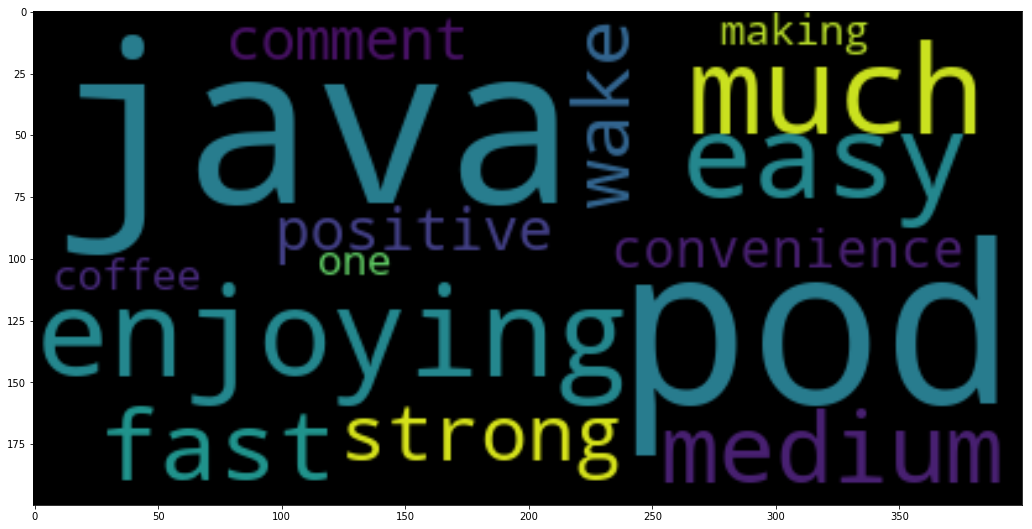

In [101]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
plt.figure(figsize=(60,20))
plt.subplot(2, 1, 1)
   
wordcloud = WordCloud().generate(groups[0])


plt.imshow(wordcloud, interpolation='bilinear')
    
    



### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

In [3]:
# Please write all the code with proper documentation

# [6] Conclusions

In [104]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan
# Please compare all your models using Prettytable library
# Please compare all your models using Prettytable library
# reference from "http://zetcode.com/python/prettytable/"
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ["algorithm", "featurization","inertia_values","best_k" ]
t.add_row(["kmeans","bow",39682.2192,8])
t.add_row(["random_forest","tfidf",45224.0925,9])
t.add_row(["random_forest","avg w2v",5917.9136,8])
t.add_row(["random_forest","tfidf avg w2v",37544.4942,8])
print(t)

+---------------+---------------+----------------+--------+
|   algorithm   | featurization | inertia_values | best_k |
+---------------+---------------+----------------+--------+
|     kmeans    |      bow      |   39682.2192   |   8    |
| random_forest |     tfidf     |   45224.0925   |   9    |
| random_forest |    avg w2v    |   5917.9136    |   8    |
| random_forest | tfidf avg w2v |   37544.4942   |   8    |
+---------------+---------------+----------------+--------+


Conclusion:bow clustered into clusters of similar words like"chai","coffee" into one category

In [105]:
t = PrettyTable()
t.field_names = ["algorithm", "featurization","best_k" ]
t.add_row(["agg_clustering","avg w2v",8])
t.add_row(["agg_clustering","tfidf w2v",8])
print(t)

+----------------+---------------+--------+
|   algorithm    | featurization | best_k |
+----------------+---------------+--------+
| agg_clustering |    avg w2v    |   8    |
| agg_clustering |   tfidf w2v   |   8    |
+----------------+---------------+--------+


Conclusion:DBSCAN doesn't work properly on this data as there are many outliers.

In [106]:
t = PrettyTable()
t.field_names = ["algorithm", "featurization","best_eps","min_points"]
t.add_row(["DBSCAN","avg w2v",0.2,100])
t.add_row(["DBSCAN","tfidf w2v",3,40])
print(t)

+-----------+---------------+----------+------------+
| algorithm | featurization | best_eps | min_points |
+-----------+---------------+----------+------------+
|   DBSCAN  |    avg w2v    |   0.2    |    100     |
|   DBSCAN  |   tfidf w2v   |    3     |     40     |
+-----------+---------------+----------+------------+
